In [1]:
!pip install amsterdamumcdb


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.5/273.5 kB 5.8 MB/s eta 0:00:00


In [2]:
import os
from google.colab import auth
%load_ext google.colab.data_table
from google.colab.data_table import DataTable
from google.cloud.bigquery import magics
from google.cloud import bigquery
import amsterdamumcdb as adb
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import re
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import io
from IPython.display import display, HTML, Markdown


In [10]:
%%bigquery admissions
SELECT * FROM admissions

Executing query with job ID: bf7cc55b-d086-42bd-a9fc-92cd8f1401cf
Query executing: 1.64s


ERROR:
 403 Access Denied: Table amsterdamumcdb:version1_0_2.admissions: User does not have permission to query table amsterdamumcdb:version1_0_2.admissions, or perhaps it does not exist in location EU.

Location: EU
Job ID: bf7cc55b-d086-42bd-a9fc-92cd8f1401cf



In [11]:
admissions=admissions

In [ ]:
admissions["los_days"] = round(admissions["lengthofstay"]//24, 0)+1
admissions.head(5)
#added column lenght_of_stay in days

#LoS outliers processing

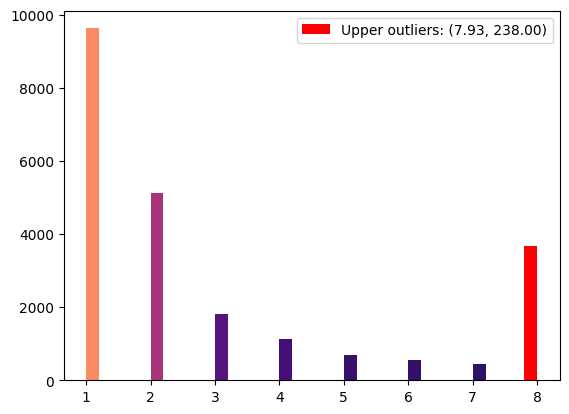

In [ ]:
adb.outliers_histogram(data=admissions["los_days"]).show()

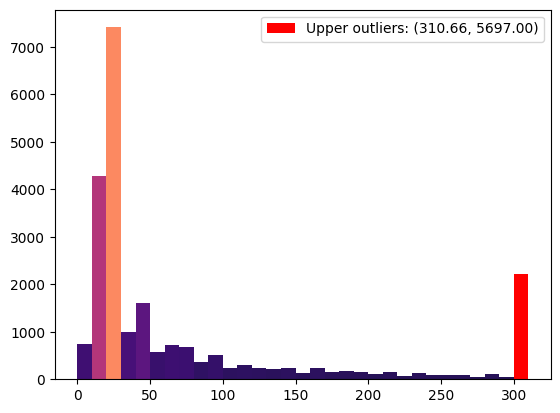

In [ ]:
adb.outliers_histogram(data=admissions["lengthofstay"], z_threshold=16).show()

#Prediction of **LOS**

# processingfunc

In [ ]:
def age_conversion(str):
  if str == "18-39":
    return 37
  elif str == "40-49":
    return 45
  elif str == "50-59":
    return 55
  elif str == "60-69":
    return 65
  elif str == "70-79":
    return 75
  elif str == "80+":
    return 85

In [ ]:
def weight_conversion(str):
  if str == "59-":
    return 55
  elif str == "60-69":
    return 65
  elif str == "70-79":
    return 75
  elif str == "80-89":
    return 85
  elif str == "90-99":
    return 95
  elif str == "100-109":
    return 105
  elif str == "110+":
    return 115


In [ ]:
def height_conversion(str):
  if str == "159-":
    return 155
  elif str == "160-169":
    return 165
  elif str == "170-179":
    return 175
  elif str == "180-189":
    return 185
  elif str == "190+":
    return 195



#db processing

In [ ]:
admissions["mortality"] = np.where(admissions["destination"]=="Overleden", 1, 0)
admissions.head(5)
admissions["mortality"].value_counts()
#column "mortality" means 1 if admission ended with death in ICU and 0 if patient was transferred to another unit alive

0    20818
1     2288
Name: mortality, dtype: int64

In [ ]:
admissions["age_number"] = admissions["agegroup"].apply(lambda x: age_conversion(x))
admissions["weight_number"] = admissions["weightgroup"].apply(lambda x: weight_conversion(x))
admissions["height_number"] = admissions["heightgroup"].apply(lambda x: height_conversion(x))
admissions["BMI"] = round(admissions["weight_number"]/(admissions["height_number"]/100)**2, 0)
#Creation of separate columns with presumable numeric value of age, weight and height and calculation of BMI

In [ ]:
#The "master" dataset which will contain all variables to be used in prediction of LoS and ICU simulation
admissions_master = admissions[["admissionid", "patientid", "location", "specialty", "urgency", "mortality", "lengthofstay", "los_days", "age_number", "BMI"]]
admissions_master.head()

In [ ]:
admissions_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23106 entries, 0 to 23105
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   admissionid   23106 non-null  Int64  
 1   patientid     23106 non-null  Int64  
 2   location      23106 non-null  object 
 3   specialty     21805 non-null  object 
 4   urgency       23106 non-null  Int64  
 5   mortality     23106 non-null  int64  
 6   lengthofstay  23106 non-null  Int64  
 7   los_days      23106 non-null  Int64  
 8   age_number    23106 non-null  int64  
 9   BMI           21624 non-null  float64
dtypes: Int64(5), float64(1), int64(2), object(2)
memory usage: 1.9+ MB


#Features selection and processing

In [ ]:
#function for left (sql) join of datasets for adding variables for los predictions
def left_join(df1, df2):
  df1=pd.merge(left=df1,
         right=df2,
         how = "left",
         on="admissionid")
  return df1

In [ ]:
%%bigquery pao2_fio2
     WITH fio2_table AS (
    SELECT n.admissionid,
        n.measuredat,
        l.valueid,
        l.value AS o2_device,
        CASE
            WHEN n.itemid IN (
                --FiO2 settings on respiratory support
                6699, --FiO2 %: setting on Evita ventilator
                12279, --O2 concentratie --measurement by Servo-i/Servo-U ventilator
                12369, --SET %O2: used with BiPap Vision ventilator
                16246 --Zephyros FiO2: Non-invasive ventilation
            ) THEN TRUE
            ELSE FALSE
        END AS ventilatory_support,
        n.itemid,
        CASE
            WHEN n.itemid IN (
                --FiO2 settings on respiratory support
                6699, --FiO2 %: setting on Evita ventilator
                12279, --O2 concentratie --measurement by Servo-i/Servo-U ventilator
                12369, --SET %O2: used with BiPap Vision ventilator
                16246 --Zephyros FiO2: Non-invasive ventilation
            ) THEN
                CASE
                    WHEN NOT n.value IS NULL THEN n.value --use the settings
                    ELSE 0.21
                END
            ELSE -- estimate the FiO2
                CASE
                    WHEN l.valueid IN (
                        2, -- Nasaal
                        7 --O2-bril
                    ) THEN
                        CASE
                            WHEN n.value >= 1 AND n.value < 2 THEN 0.22
                            WHEN n.value >= 2 AND n.value < 3 THEN 0.25
                            WHEN n.value >= 3 AND n.value < 4 THEN 0.27
                            WHEN n.value >= 4 AND n.value < 5 THEN 0.30
                            WHEN n.value >= 5 THEN 0.35
                            ELSE 0.21
                        END
                    WHEN l.valueid IN (
                        1, --Diep Nasaal
                        3, --Kapje
                        8, --Kinnebak
                        9, --Nebulizer
                        4, --Kunstneus
                        18, --Spreekcanule
                        19 --Spreekklepje
                    ) THEN
                        CASE
                            WHEN n.value >= 1 AND n.value < 2 THEN 0.22 -- not defined by NICE
                            WHEN n.value >= 2 AND n.value < 3 THEN 0.25
                            WHEN n.value >= 3 AND n.value < 4 THEN 0.27
                            WHEN n.value >= 4 AND n.value < 5 THEN 0.30
                            WHEN n.value >= 5 AND n.value < 6 THEN 0.35
                            WHEN n.value >= 6 AND n.value < 7 THEN 0.40
                            WHEN n.value >= 7 AND n.value < 8 THEN 0.45
                            WHEN n.value >= 8 THEN 0.50
                            ELSE 0.21
                        END
                    WHEN l.valueid IN (
                        10, --Waterset
                        11, --Trach.stoma
                        13, --Ambu
                        14, --Guedel
                        15, --DL-tube
                        16, --CPAP
                        17 --Non-Rebreathing masker
                    ) THEN
                        CASE
                            WHEN n.value >= 6 AND n.value < 7 THEN 0.60
                            WHEN n.value >= 7 AND n.value < 8 THEN 0.70
                            WHEN n.value >= 8 AND n.value < 9 THEN 0.80
                            WHEN n.value >= 9 AND n.value < 10 THEN 0.85
                            WHEN n.value >= 10 THEN 0.90
                            ELSE 0.21
                        END
                    WHEN l.valueid IN (
                        12 --B.Lucht
                    ) THEN 0.21
                ELSE 0.21
            END
        END AS fio2
    FROM numericitems n
    LEFT JOIN admissions a ON
        n.admissionid = a.admissionid
    LEFT JOIN listitems l ON
        n.admissionid = l.admissionid AND
        n.measuredat = l.measuredat AND
        l.itemid = 8189 -- Toedieningsweg (Oxygen device)
    WHERE
        n.itemid IN (
            --Oxygen Flow settings without respiratory support
            8845, -- O2 l/min
            10387, --Zuurstof toediening (bloed)
            18587, --Zuurstof toediening

            --FiO2 settings on respiratory support
            6699, --FiO2 %: setting on Evita ventilator
            12279, --O2 concentratie --measurement by Servo-i/Servo-U ventilator
            12369, --SET %O2: used with BiPap Vision ventilator
            16246 --Zephyros FiO2: Non-invasive ventilation
        )
    --measurements within 24 hours of ICU stay:
    AND (n.measuredat - a.admittedat) <= 1000*60*60*24 AND (n.measuredat - a.admittedat) >= 0
    AND n.value > 0 --ignore stand by values from Evita ventilator
),
oxygenation AS (
    SELECT
        pao2.admissionid,
        CASE pao2.unitid
            WHEN 152 THEN ROUND(CAST(pao2.value * 7.50061683 AS NUMERIC), 1) -- Conversion: kPa to mmHg
            ELSE pao2.value
        END AS pao2,
        f.value AS specimen_source,
        CASE
            WHEN UPPER(pao2.registeredby) NOT LIKE UPPER('%Systeem%') THEN TRUE
            ELSE FALSE
        END AS manual_entry,
        (pao2.measuredat - a.admittedat)/(1000*60) AS time,
        fio2_table.fio2,
        fio2_table.ventilatory_support,
        (fio2_table.measuredat - pao2.measuredat)/(60*1000) AS fio2_time_difference,
        ROW_NUMBER() OVER(
            PARTITION BY pao2.admissionid, pao2.measuredat
            ORDER BY
                CASE
                    --FiO2 settings on respiratory support
                    WHEN fio2_table.itemid = 12279 THEN 1 --O2 concentratie --measurement by Servo-i/Servo-U ventilator
                    WHEN fio2_table.itemid = 6699 THEN 2 --FiO2 %: setting on Evita ventilator
                    WHEN fio2_table.itemid = 12369 THEN 3 --SET %O2: used with BiPap Vision ventilator
                    WHEN fio2_table.itemid = 16246 THEN 4--Zephyros FiO2: Non-invasive ventilation
                    --Oxygen Flow settings without respiratory support
                    WHEN fio2_table.itemid = 8845 THEN 5 -- O2 l/min
                    WHEN fio2_table.itemid = 10387 THEN 6 --Zuurstof toediening (bloed)
                    WHEN fio2_table.itemid = 18587 THEN 7 --Zuurstof toediening
                END, --prefer ventilator measurements over manually entered O2 settings
                CASE
                    WHEN fio2_table.measuredat <= pao2.measuredat THEN 1 --prefer FiO2 settings before blood gas measurement
                    ELSE 2
                END,
                ABS(fio2_table.measuredat - pao2.measuredat), --prefer FiO2 settings nearest to blood gas measurement
                CASE
                    WHEN pao2.itemid = 21214 THEN 1 --PO2 (bloed) - kPa
                    WHEN pao2.itemid = 9996 THEN 2 --PO2 (bloed)
                    WHEN pao2.itemid = 7433 THEN 3 --PO2
                END, --prefer PaO2 values from original measurement unit; same measurement could be reported twice
                CASE
                    WHEN paco2.itemid = 21213 THEN 1--PCO2 (bloed) - kPa
                    WHEN paco2.itemid = 9990 THEN 2 --pCO2 (bloed)
                    WHEN  paco2.itemid = 6846 THEN 3 --PCO2
                END, --prefer PaCO2 values from original measurement unit; same measurement could be reported twice
                CASE
                    WHEN UPPER(f.value) LIKE UPPER('%art%') THEN 1
                    ELSE 2
                END, --prefer samples that haven been specified as arterial
                fio2_table.fio2 DESC --prefer highest (calculated) FiO2 for rare cases with multiple oxygen devices
        ) AS priority
    FROM numericitems pao2
    LEFT JOIN admissions a ON
        pao2.admissionid = a.admissionid
    LEFT JOIN freetextitems f ON
        pao2.admissionid = f.admissionid AND
        pao2.measuredat = f.measuredat AND
        f.itemid = 11646 --Afname (bloed): source of specimen
    LEFT JOIN numericitems paco2 ON
        pao2.admissionid = paco2.admissionid AND
        pao2.measuredat = paco2.measuredat AND
        paco2.itemid IN (
            6846, --PCO2
            9990, --pCO2 (bloed)
            21213 --PCO2 (bloed) - kPa
        )
    LEFT JOIN fio2_table ON
        pao2.admissionid = fio2_table.admissionid AND
        fio2_table.measuredat > pao2.measuredat - 60*60*1000 AND --no earlier than 60 minutes before pao2 measurement
        fio2_table.measuredat < pao2.measuredat + 15*60*1000 --no later than 15 minutes after pao2 measurement
    WHERE
        pao2.itemid IN (
            7433, --PO2
            9996, --PO2 (bloed)
            21214 --PO2 (bloed) - kPa
        )
    --measurements within 24 hours of ICU stay (use 30 minutes before admission to allow for time differences):
    AND (pao2.measuredat - a.admittedat) <= 1000*60*60*24 AND (pao2.measuredat - a.admittedat) >= -(1000*60*30) AND
    (UPPER(f.value) LIKE UPPER('%art%') OR f.value IS NULL)  -- source is arterial or undefined (assume arterial)
)
SELECT * FROM oxygenation
WHERE priority = 1


Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
pao2_fio2 = pao2_fio2
pao2_fio2.describe()

,admissionid,pao2,time,fio2,fio2_time_difference,priority
count,155784.0,155784.000000,155784.000000,128200.000000,128200.000000,155784.0
mean,11769.260534,113.975209,569.234344,32.488629,-18.149080,1.0
std,6784.435407,57.730326,414.314923,26.112568,18.966767,0.0
min,0.0,0.000000,-30.000000,0.210000,-59.000000,1.0
25%,5875.75,80.000000,198.000000,0.350000,-32.000000,1.0
50%,11784.5,100.000000,509.000000,40.000000,-13.000000,1.0
75%,17615.0,131.000000,901.000000,50.000000,0.000000,1.0
max,23551.0,2127.000000,1440.000000,570.000000,14.000000,1.0


In [ ]:
pao2_fio2.head(5)

,admissionid,pao2,specimen_source,manual_entry,time,fio2,ventilatory_support,fio2_time_difference,priority
0,933,89.0,None,True,1164.0,0.35,False,1.0,1
1,4070,139.0,None,True,50.0,60.00,True,7.0,1
2,4490,79.0,ART.,False,24.0,0.35,False,9.0,1
3,4531,114.0,ART.,False,-2.0,40.00,True,4.0,1
4,5019,111.0,None,True,8.0,60.00,True,12.0,1


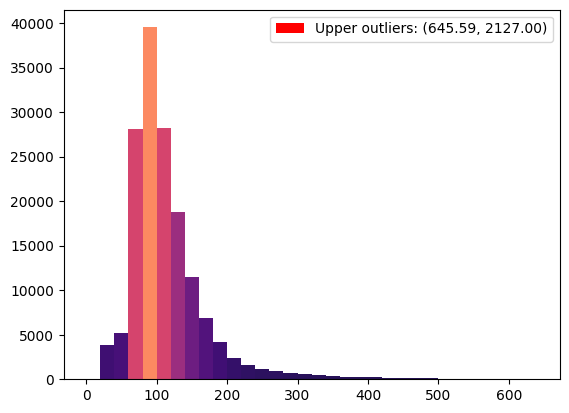

In [ ]:
adb.outliers_histogram(data=pao2_fio2["pao2"], z_threshold=16).show()

In [ ]:
pao2_fio2 = pao2_fio2[(pao2_fio2["pao2"]<645.59) & (pao2_fio2["pao2"]>50)]

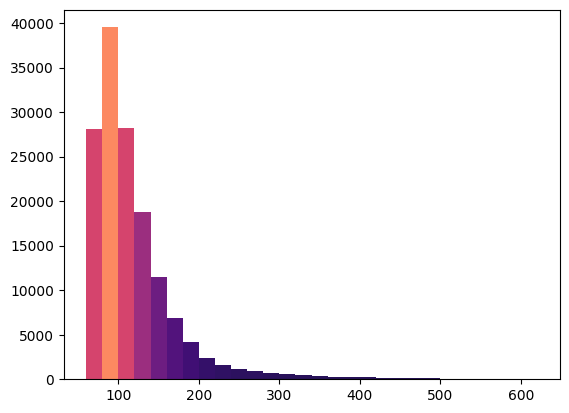

In [ ]:
adb.outliers_histogram(data=pao2_fio2["pao2"], z_threshold=16).show()

In [ ]:
pao2_fio2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149769 entries, 0 to 155783
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   admissionid           149769 non-null  Int64  
 1   pao2                  149769 non-null  float64
 2   specimen_source       113887 non-null  object 
 3   manual_entry          149769 non-null  boolean
 4   time                  149769 non-null  float64
 5   fio2                  123073 non-null  float64
 6   ventilatory_support   123073 non-null  boolean
 7   fio2_time_difference  123073 non-null  float64
 8   priority              149769 non-null  Int64  
dtypes: Int64(2), boolean(2), float64(4), object(1)
memory usage: 10.0+ MB


In [ ]:
pao2_fio2['fio2'] = pao2_fio2['fio2'].apply(lambda x: x*100 if x<1 else x)
pao2_fio2.head(5)

,admissionid,pao2,specimen_source,manual_entry,time,fio2,ventilatory_support,fio2_time_difference,priority
0,933,89.0,None,True,1164.0,35.0,False,1.0,1
1,4070,139.0,None,True,50.0,60.0,True,7.0,1
2,4490,79.0,ART.,False,24.0,35.0,False,9.0,1
3,4531,114.0,ART.,False,-2.0,40.0,True,4.0,1
4,5019,111.0,None,True,8.0,60.0,True,12.0,1


In [ ]:
pao2_fio2 = pao2_fio2[(pao2_fio2["fio2"]>21.0)&(pao2_fio2["fio2"]<100.0)]

In [ ]:
pao2_fio2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118996 entries, 0 to 155783
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   admissionid           118996 non-null  Int64  
 1   pao2                  118996 non-null  float64
 2   specimen_source       86962 non-null   object 
 3   manual_entry          118996 non-null  boolean
 4   time                  118996 non-null  float64
 5   fio2                  118996 non-null  float64
 6   ventilatory_support   118996 non-null  boolean
 7   fio2_time_difference  118996 non-null  float64
 8   priority              118996 non-null  Int64  
dtypes: Int64(2), boolean(2), float64(4), object(1)
memory usage: 7.9+ MB


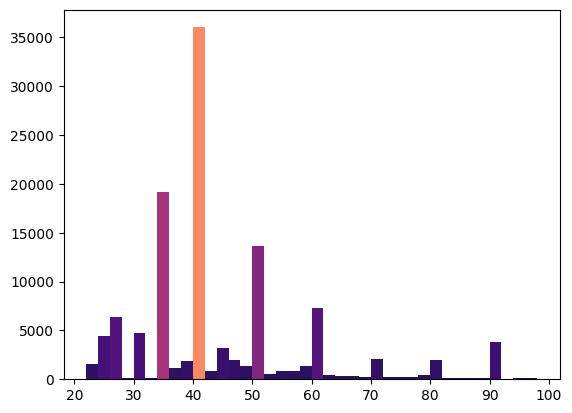

In [ ]:
adb.outliers_histogram(data=pao2_fio2["fio2"], z_threshold=16).show()

In [ ]:
pao2_fio2['pao2/fio2']= round(pao2_fio2['pao2']/pao2_fio2['fio2']*100,0)
pao2_fio2.head(5)
pao2_fio2['pao2/fio2'].describe()

count    118996.000000
mean        272.037052
std         123.387130
min          52.000000
25%         186.000000
50%         251.000000
75%         340.000000
max        1873.000000
Name: pao2/fio2, dtype: float64

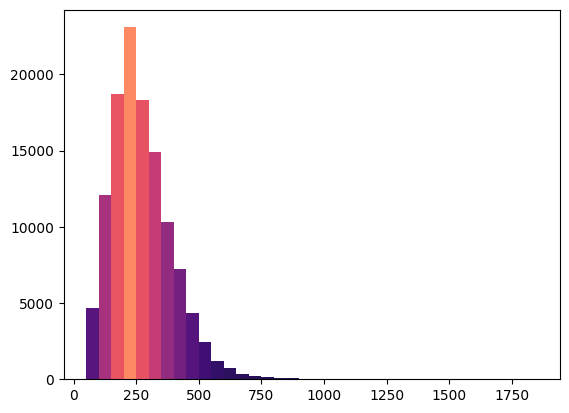

In [ ]:
adb.outliers_histogram(data=pao2_fio2['pao2/fio2'], z_threshold=16).show()

In [ ]:
#calculate SOFA respiration score:
pao2_fio2.loc[:,'sofa_respiration_score'] = 0
pao2_fio2.loc[(pao2_fio2['pao2/fio2'] < 400) &
                     (pao2_fio2['pao2/fio2'] >= 300), 'sofa_respiration_score'] = 1
pao2_fio2.loc[(pao2_fio2['pao2/fio2'] < 300), 'sofa_respiration_score'] = 2
pao2_fio2.loc[(pao2_fio2['pao2/fio2'] < 200) & (pao2_fio2['pao2/fio2'] >= 100) &
                     (pao2_fio2['ventilatory_support'] == True), 'sofa_respiration_score'] = 3
pao2_fio2.loc[(pao2_fio2['pao2/fio2'] < 100) &
                     (pao2_fio2['ventilatory_support'] == True), 'sofa_respiration_score'] = 4
pao2_fio2.head()

,admissionid,pao2,specimen_source,manual_entry,time,fio2,ventilatory_support,fio2_time_difference,priority,pao2/fio2,sofa_respiration_score
0,933,89.0,None,True,1164.0,35.0,False,1.0,1,254.0,2
1,4070,139.0,None,True,50.0,60.0,True,7.0,1,232.0,2
2,4490,79.0,ART.,False,24.0,35.0,False,9.0,1,226.0,2
3,4531,114.0,ART.,False,-2.0,40.0,True,4.0,1,285.0,2
4,5019,111.0,None,True,8.0,60.0,True,12.0,1,185.0,3


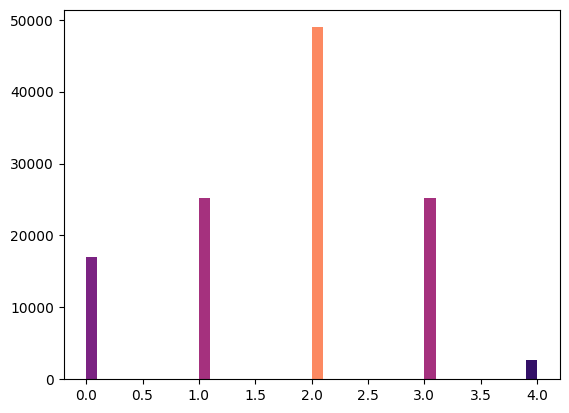

In [ ]:
adb.outliers_histogram(data=pao2_fio2['sofa_respiration_score'], z_threshold=16).show()

In [ ]:
pao2_fio2_tomerge = pao2_fio2[['admissionid', "sofa_respiration_score"]]
pao2_fio2_tomerge

,admissionid,sofa_respiration_score
0,933,2
1,4070,2
2,4490,2
3,4531,2
4,5019,3
...,...,...
155779,15728,0
155780,16906,1
155781,17020,2
155782,21468,2


In [ ]:
pao2_fio2_tomerge.describe()

,admissionid,sofa_respiration_score
count,118996.0,118996.000000
mean,11765.292413,1.759639
std,6777.313973,1.013499
min,0.0,0.000000
25%,5883.0,1.000000
50%,11798.0,2.000000
75%,17590.0,2.000000
max,23551.0,4.000000


In [ ]:
pao2_fio2_tomerge = pao2_fio2_tomerge.groupby('admissionid').agg(max)
pao2_fio2_tomerge


,sofa_respiration_score
admissionid,
0,3
1,2
2,2
3,2
4,3
...,...
23546,3
23547,3
23548,1


In [ ]:
admissions_master.head(5)

,admissionid,patientid,location,specialty,urgency,mortality,lengthofstay,los_days,age_number,BMI
0,130,117,MC,None,0,0,26,2,75,22.0
1,656,570,MC,None,0,0,25,2,75,24.0
2,799,700,MC,None,0,0,29,2,65,24.0
3,941,817,MC,None,0,0,24,2,75,24.0
4,1098,951,MC,None,0,0,20,1,75,21.0


In [ ]:
admissions_master = left_join(admissions_master, pao2_fio2_tomerge)


In [ ]:
admissions_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23106 entries, 0 to 23105
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   admissionid             23106 non-null  Int64  
 1   patientid               23106 non-null  Int64  
 2   location                23106 non-null  object 
 3   specialty               21805 non-null  object 
 4   urgency                 23106 non-null  Int64  
 5   mortality               23106 non-null  int64  
 6   lengthofstay            23106 non-null  Int64  
 7   los_days                23106 non-null  Int64  
 8   age_number              23106 non-null  int64  
 9   BMI                     21624 non-null  float64
 10  sofa_respiration_score  20189 non-null  float64
dtypes: Int64(5), float64(2), int64(2), object(2)
memory usage: 2.2+ MB


In [ ]:
%%bigquery coagulation_sofa

    SELECT
    n.admissionid,
    n.itemid,
    n.item,
    n.value,
    n.registeredby,
    CASE
        WHEN UPPER(n.registeredby) NOT LIKE UPPER('%Systeem%') THEN TRUE
        ELSE FALSE
    END AS manual_entry,
    (n.measuredat - a.admittedat)/(1000*60) AS time
FROM numericitems n
LEFT JOIN admissions a ON
    n.admissionid = a.admissionid
WHERE n.itemid IN (
    9964, --Thrombo's (bloed)
    6797, --Thrombocyten
    10409, --Thrombo's citr. bloed (bloed)
    14252 --Thrombo CD61 (bloed)
    )
--measurements within 24 hours of ICU stay (use 30 minutes before admission to allow for time differences):
AND (n.measuredat - a.admittedat) <= 1000*60*60*24 AND (n.measuredat - a.admittedat) >= -(1000*60*30)


Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
platelets_sofa = coagulation_sofa
platelets_sofa.head()

,admissionid,itemid,item,value,registeredby,manual_entry,time
0,11036,10409,Thrombo's citr. bloed (bloed),6.0,Systeem,False,1278.0
1,14457,10409,Thrombo's citr. bloed (bloed),11.0,Systeem,False,403.0
2,5605,10409,Thrombo's citr. bloed (bloed),19.0,Systeem,False,152.0
3,21365,10409,Thrombo's citr. bloed (bloed),26.0,Systeem,False,1300.0
4,8479,10409,Thrombo's citr. bloed (bloed),44.0,Systeem,False,1224.0


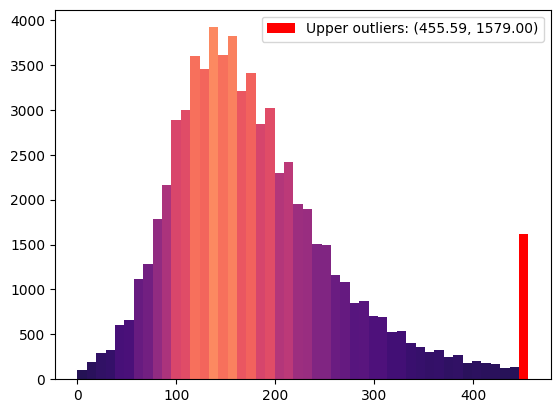

In [ ]:
adb.outliers_histogram(data=platelets_sofa['value'],bins=48).show()


In [ ]:
platelets_sofa.loc[platelets_sofa["value"]>1000]
#all values ware entered by system, not manually, so they will be included in analysis

,admissionid,itemid,item,value,registeredby,manual_entry,time
13490,6914,9964,Thrombo's (bloed),1024.0,Systeem,False,158.0
13491,11592,9964,Thrombo's (bloed),1216.0,Systeem,False,1012.0
13495,17728,9964,Thrombo's (bloed),1025.0,Systeem,False,57.0
13496,16650,9964,Thrombo's (bloed),1089.0,Systeem,False,392.0
13524,17562,9964,Thrombo's (bloed),1090.0,Systeem,False,656.0
14262,11592,9964,Thrombo's (bloed),1351.0,Systeem,False,475.0
19520,5321,9964,Thrombo's (bloed),1097.0,Systeem,False,-17.0
29249,22058,9964,Thrombo's (bloed),1107.0,Systeem,False,39.0
29975,104,9964,Thrombo's (bloed),1109.0,Systeem,False,1007.0
30006,20923,9964,Thrombo's (bloed),1111.0,Systeem,False,480.0


In [ ]:
platelets_sofa.rename(columns={"value":"platelets"}, inplace=True)

In [ ]:
#calculate SOFA coagulation score:
platelets_sofa.loc[:,'sofa_coagulation_score'] = 0
platelets_sofa.loc[(platelets_sofa['platelets'] < 150) &
                     (platelets_sofa['platelets'] >= 100), 'sofa_coagulation_score'] = 1
platelets_sofa.loc[(platelets_sofa['platelets'] < 100) &
                     (platelets_sofa['platelets'] >= 50), 'sofa_coagulation_score'] = 2
platelets_sofa.loc[(platelets_sofa['platelets'] < 50) &
                     (platelets_sofa['platelets'] >= 20), 'sofa_coagulation_score'] = 3
platelets_sofa.loc[(platelets_sofa['platelets'] < 20), 'sofa_coagulation_score'] = 4

platelets_sofa.head()

,admissionid,itemid,item,platelets,registeredby,manual_entry,time,sofa_coagulation_score
0,11036,10409,Thrombo's citr. bloed (bloed),6.0,Systeem,False,1278.0,4
1,14457,10409,Thrombo's citr. bloed (bloed),11.0,Systeem,False,403.0,4
2,5605,10409,Thrombo's citr. bloed (bloed),19.0,Systeem,False,152.0,4
3,21365,10409,Thrombo's citr. bloed (bloed),26.0,Systeem,False,1300.0,3
4,8479,10409,Thrombo's citr. bloed (bloed),44.0,Systeem,False,1224.0,3


In [ ]:
platelets_tomerge = platelets_sofa[['admissionid', "sofa_coagulation_score"]]
platelets_tomerge = platelets_tomerge.groupby('admissionid').agg(max)
admissions_master = left_join(admissions_master, platelets_tomerge)
admissions_master

,admissionid,patientid,location,specialty,urgency,mortality,lengthofstay,los_days,age_number,BMI,...,bilirubin,sofa_liver_score,sofa_cardiovascular_score,sofa_cns_score,sofa_renal_score,sofa_total,sepsis_at_admission,surgical,hematocrit,sofa_coagulation_score_y
0,130,117,MC,None,0,0,26,2,75,22.0,...,10.0,0.0,2.0,NaN,0.0,NaN,<NA>,<NA>,29.0,1.0
1,656,570,MC,None,0,0,25,2,75,24.0,...,10.0,0.0,1.0,0.0,1.0,5.0,<NA>,<NA>,23.0,2.0
2,799,700,MC,None,0,0,29,2,65,24.0,...,10.0,0.0,2.0,NaN,0.0,NaN,<NA>,<NA>,25.0,2.0
3,941,817,MC,None,0,0,24,2,75,24.0,...,10.0,0.0,2.0,NaN,0.0,NaN,<NA>,<NA>,26.0,1.0
4,1098,951,MC,None,0,0,20,1,75,21.0,...,10.0,0.0,1.0,NaN,0.0,NaN,<NA>,<NA>,26.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23101,23348,20155,MC&IC,Nefrologie,0,1,65,3,65,28.0,...,10.0,0.0,1.0,0.0,4.0,7.0,0,0,29.0,0.0
23102,23437,20229,IC,Cardiologie,1,1,84,4,75,19.0,...,5.0,0.0,4.0,4.0,3.0,12.0,<NA>,0,24.0,0.0
23103,23459,20246,IC,Vaatchirurgie,0,1,62,3,55,28.0,...,23.0,1.0,4.0,NaN,1.0,NaN,<NA>,1,27.0,0.0
23104,23483,20266,IC,Heelkunde Oncologie,0,1,26,2,65,22.0,...,67.0,2.0,4.0,NaN,3.0,NaN,1,1,25.0,0.0


In [ ]:
%%bigquery bilirubin_sofa
   SELECT
    n.admissionid,
    n.itemid,
    n.item,
    n.value,
    n.registeredby,
    CASE
        WHEN UPPER(n.registeredby) NOT LIKE UPPER('%Systeem%') THEN TRUE
        ELSE FALSE
    END AS manual_entry,
    (n.measuredat - a.admittedat)/(1000*60) AS time
FROM numericitems n
LEFT JOIN admissions a ON
    n.admissionid = a.admissionid
    WHERE n.itemid IN (
        6813, --Bili Totaal
        9945 --Bilirubine (bloed)
    )
--measurements within 24 hours of ICU stay (use 30 minutes before admission to allow for time differences):
AND (n.measuredat - a.admittedat) <= 1000*60*60*24 AND (n.measuredat - a.admittedat) >= -(1000*60*30)


Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
bilirubin_sofa =bilirubin_sofa
bilirubin_sofa

,admissionid,itemid,item,value,registeredby,manual_entry,time
0,16384,6813,Bili Totaal,20.0,ICV_IC-Verpleegkundig,True,13.0
1,12290,6813,Bili Totaal,97.0,ICV_IC-Verpleegkundig,True,1142.0
2,12290,6813,Bili Totaal,109.0,ICV_IC-Verpleegkundig,True,62.0
3,4355,6813,Bili Totaal,43.0,ICV_IC-Verpleegkundig,True,1040.0
4,4355,6813,Bili Totaal,49.0,ICV_IC-Verpleegkundig,True,560.0
...,...,...,...,...,...,...,...
15753,11769,9945,Bilirubine (bloed),318.0,Systeem,False,37.0
15754,19494,9945,Bilirubine (bloed),318.0,Systeem,False,28.0
15755,4561,9945,Bilirubine (bloed),366.0,Systeem,False,1151.0
15756,4078,9945,Bilirubine (bloed),462.0,Systeem,False,61.0


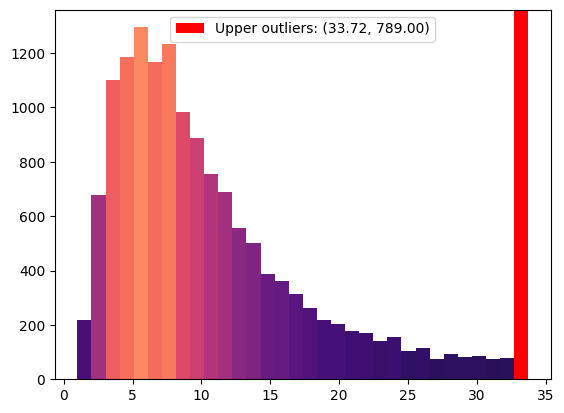

In [ ]:
adb.outliers_histogram(data=bilirubin_sofa['value'],bins=32).show()


In [ ]:
bilirubin_sofa[bilirubin_sofa['value'].isna()]

,admissionid,itemid,item,value,registeredby,manual_entry,time


In [ ]:
#calculate SOFA liver score:
bilirubin_sofa.loc[:,'sofa_liver_score'] = 0
bilirubin_sofa.loc[(bilirubin_sofa['value'] >= 20) & (bilirubin_sofa['value'] < 33), 'sofa_liver_score'] = 1
bilirubin_sofa.loc[(bilirubin_sofa['value'] >= 33) & (bilirubin_sofa['value'] < 102), 'sofa_liver_score'] = 2
bilirubin_sofa.loc[(bilirubin_sofa['value'] >= 102) & (bilirubin_sofa['value'] < 204), 'sofa_liver_score'] = 3
bilirubin_sofa.loc[(bilirubin_sofa['value'] >= 204), 'sofa_liver_score'] = 4

bilirubin_sofa.head()

,admissionid,itemid,item,value,registeredby,manual_entry,time,sofa_liver_score
0,16384,6813,Bili Totaal,20.0,ICV_IC-Verpleegkundig,True,13.0,1
1,12290,6813,Bili Totaal,97.0,ICV_IC-Verpleegkundig,True,1142.0,2
2,12290,6813,Bili Totaal,109.0,ICV_IC-Verpleegkundig,True,62.0,3
3,4355,6813,Bili Totaal,43.0,ICV_IC-Verpleegkundig,True,1040.0,2
4,4355,6813,Bili Totaal,49.0,ICV_IC-Verpleegkundig,True,560.0,2


In [ ]:
bilirubin_median = bilirubin_sofa["bilirubin"].median()
bilirubin_median

10.0

In [ ]:
bilirubin_tomerge = bilirubin_sofa[['admissionid', "sofa_liver_score"]]
bilirubin_tomerge = bilirubin_tomerge.groupby('admissionid').agg(max)
admissions_master = left_join(admissions_master, bilirubin_tomerge)

In [ ]:
admissions_master["sofa_liver_score"].fillna(value=0, inplace=True)
# Nan values for bilirubin replaced with medial value of 10, and sofa score with normal value 0

In [ ]:
admissions_master

,admissionid,patientid,location,specialty,urgency,mortality,lengthofstay,los_days,age_number,BMI,...,sofa_cardiovascular_score,sofa_cns_score,sofa_renal_score,sofa_total,sepsis_at_admission,surgical,hematocrit,sofa_coagulation_score_y,sofa_liver_score_y,sofa_liver_score
0,130,117,MC,None,0,0,26,2,75,22.0,...,2.0,NaN,0.0,NaN,<NA>,<NA>,29.0,1.0,NaN,0.0
1,656,570,MC,None,0,0,25,2,75,24.0,...,1.0,0.0,1.0,5.0,<NA>,<NA>,23.0,2.0,NaN,0.0
2,799,700,MC,None,0,0,29,2,65,24.0,...,2.0,NaN,0.0,NaN,<NA>,<NA>,25.0,2.0,NaN,0.0
3,941,817,MC,None,0,0,24,2,75,24.0,...,2.0,NaN,0.0,NaN,<NA>,<NA>,26.0,1.0,NaN,0.0
4,1098,951,MC,None,0,0,20,1,75,21.0,...,1.0,NaN,0.0,NaN,<NA>,<NA>,26.0,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23101,23348,20155,MC&IC,Nefrologie,0,1,65,3,65,28.0,...,1.0,0.0,4.0,7.0,0,0,29.0,0.0,NaN,0.0
23102,23437,20229,IC,Cardiologie,1,1,84,4,75,19.0,...,4.0,4.0,3.0,12.0,<NA>,0,24.0,0.0,0.0,0.0
23103,23459,20246,IC,Vaatchirurgie,0,1,62,3,55,28.0,...,4.0,NaN,1.0,NaN,<NA>,1,27.0,0.0,2.0,2.0
23104,23483,20266,IC,Heelkunde Oncologie,0,1,26,2,65,22.0,...,4.0,NaN,3.0,NaN,1,1,25.0,0.0,2.0,2.0


In [ ]:
%%bigquery cardiovascular_sofa

  WITH dosing AS (
    SELECT
        drugitems.admissionid,
        itemid,
        item,
        (start - admissions.admittedat)/(1000*60) AS start_time,
        (stop - admissions.admittedat)/(1000*60) AS stop_time,
        duration,
        rate,
        rateunit,
        dose,
        doseunit,
        doseunitid,
        doserateperkg,
        doserateunitid,
        doserateunit,
        CASE
            WHEN weightgroup LIKE '59' THEN 55
            WHEN weightgroup LIKE '60' THEN 65
            WHEN weightgroup LIKE '70' THEN 75
            WHEN weightgroup LIKE '80' THEN 85
            WHEN weightgroup LIKE '90' THEN 95
            WHEN weightgroup LIKE '100' THEN 105
            WHEN weightgroup LIKE '110' THEN 115
            ELSE 80 --mean weight for all years
        END as patientweight
    FROM drugitems
    LEFT JOIN admissions
    ON drugitems.admissionid = admissions.admissionid
    WHERE ordercategoryid = 65 -- continuous i.v. perfusor
    AND itemid IN (
            7179, -- Dopamine (Inotropin)
            7178, -- Dobutamine (Dobutrex)
            6818, -- Adrenaline (Epinefrine)
            7229  -- Noradrenaline (Norepinefrine)
        )
    AND rate > 0.1
)
SELECT
    admissionid,
    itemid,
    item,
    duration,
    rate,
    rateunit,
    start_time,
    stop_time,
    CASE
    --recalculate the dose to µg/kg/min ('gamma')
    WHEN doserateperkg = 0 AND doseunitid = 11 AND doserateunitid = 4 --unit: µg/min -> µg/kg/min
        THEN CASE
            WHEN patientweight > 0
            THEN dose/patientweight
            ELSE dose/80 --mean weight
        END
    WHEN doserateperkg = 0 AND doseunitid = 10 AND
    doserateunitid = 4 --unit: mg/min  -> µg/kg/min
        THEN CASE
            WHEN patientweight > 0
            THEN dose*1000/patientweight
            ELSE dose*1000/80 --mean weight
        END
    WHEN doserateperkg = 0 AND doseunitid = 10 AND doserateunitid = 5 --unit: mg/uur  -> µg/kg/min
        THEN CASE
            WHEN patientweight > 0
            THEN dose*1000/patientweight/60
            ELSE dose*1000/80 --mean weight
        END
    WHEN doserateperkg = 1 AND doseunitid = 11 AND doserateunitid = 4 --unit: µg/kg/min (no conversion needed)
        THEN dose
    WHEN doserateperkg = 1 AND doseunitid = 11 AND doserateunitid = 5 --unit: µg/kg/uur -> µg/kg/min
        THEN dose/60
    END AS gamma
FROM dosing
WHERE
    -- medication given within 24 hours of ICU stay:
    start_time <= 24*60 AND stop_time >= 0
ORDER BY admissionid, start_time;


Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
cardiovascular_sofa = cardiovascular_sofa
cardiovascular_sofa

,admissionid,itemid,item,duration,rate,rateunit,start_time,stop_time,gamma
0,1,7179,Dopamine (Inotropin),301,2.0,ml/uur,50.0,351.0,1.666667
1,2,7229,Noradrenaline (Norepinefrine),36,2.0,ml/uur,22.0,58.0,0.083333
2,2,7229,Noradrenaline (Norepinefrine),20,3.0,ml/uur,58.0,78.0,0.125000
3,2,7229,Noradrenaline (Norepinefrine),15,2.0,ml/uur,78.0,93.0,0.083333
4,2,7229,Noradrenaline (Norepinefrine),18,1.0,ml/uur,93.0,111.0,0.041667
...,...,...,...,...,...,...,...,...,...
93949,23549,7229,Noradrenaline (Norepinefrine),3,1.0,ml/uur,532.0,535.0,0.041667
93950,23549,7229,Noradrenaline (Norepinefrine),59,0.5,ml/uur,535.0,594.0,0.020833
93951,23549,7229,Noradrenaline (Norepinefrine),47,1.0,ml/uur,594.0,641.0,0.041667
93952,23549,7229,Noradrenaline (Norepinefrine),18,0.5,ml/uur,641.0,659.0,0.020833


In [ ]:
sofa_cardiovascular_meds = cardiovascular_sofa.groupby(['admissionid','itemid', 'item']).agg(
        total_duration=pd.NamedAgg(column='duration', aggfunc='sum'),
        max_gamma=pd.NamedAgg(column='gamma', aggfunc='max')
    ).reset_index()

sofa_cardiovascular_meds.head()

,admissionid,itemid,item,total_duration,max_gamma
0,1,7179,Dopamine (Inotropin),301,1.666667
1,2,7229,Noradrenaline (Norepinefrine),89,0.125000
2,4,7179,Dopamine (Inotropin),494,5.000000
3,5,7229,Noradrenaline (Norepinefrine),28,0.166667
4,7,7229,Noradrenaline (Norepinefrine),1606,0.083333


In [ ]:
#calculate SOFA cardiovascular score:
sofa_cardiovascular_meds.loc[:,'sofa_cardiovascular_score'] = 0

#dopamine (itemid 7179) <= 5 or dobutamine (itemid 7178) any dose
sofa_cardiovascular_meds.loc[(
    ((sofa_cardiovascular_meds['itemid'] == 7179) & (sofa_cardiovascular_meds['max_gamma'] <= 5)) |
    ((sofa_cardiovascular_meds['itemid'] == 7178))
), 'sofa_cardiovascular_score'] = 2

#dopamine (itemid 7179) > 5, epinephrine (itemid 6818) <= 0.1, norepinephrine (itemid 7229) <= 0.1
sofa_cardiovascular_meds.loc[(
    ((sofa_cardiovascular_meds['itemid'] == 7179) & (sofa_cardiovascular_meds['max_gamma'] > 5) &
     (sofa_cardiovascular_meds['max_gamma'] < 15)) |
    ((sofa_cardiovascular_meds['itemid'] == 6818) & (sofa_cardiovascular_meds['max_gamma'] <= 0.1)) |
    ((sofa_cardiovascular_meds['itemid'] == 7229) & (sofa_cardiovascular_meds['max_gamma'] <= 0.1))
), 'sofa_cardiovascular_score'] = 3

#dopamine (itemid 7179) > 15, epinephrine (itemid 6818) > 0.1, norepinephrine (itemid 7229) > 0.1

sofa_cardiovascular_meds.loc[(
    ((sofa_cardiovascular_meds['itemid'] == 7179) & (sofa_cardiovascular_meds['max_gamma'] > 15)) |
    ((sofa_cardiovascular_meds['itemid'] == 6818) & (sofa_cardiovascular_meds['max_gamma'] > 0.1)) |
    ((sofa_cardiovascular_meds['itemid'] == 7229) & (sofa_cardiovascular_meds['max_gamma'] > 0.1))
), 'sofa_cardiovascular_score'] = 4

sofa_cardiovascular_meds.head()

,admissionid,itemid,item,total_duration,max_gamma,sofa_cardiovascular_score
0,1,7179,Dopamine (Inotropin),301,1.666667,2
1,2,7229,Noradrenaline (Norepinefrine),89,0.125000,4
2,4,7179,Dopamine (Inotropin),494,5.000000,2
3,5,7229,Noradrenaline (Norepinefrine),28,0.166667,4
4,7,7229,Noradrenaline (Norepinefrine),1606,0.083333,3


In [ ]:
%%bigquery mean_abp

  SELECT
    n.admissionid,
    n.itemid,
    n.item,
    n.value,
    CASE
        WHEN NOT registeredby IS NULL THEN TRUE
        ELSE FALSE
    END as validated,
    (measuredat - a.admittedat)/(1000*60) AS time
FROM numericitems n
LEFT JOIN admissions a ON
n.admissionid = a.admissionid
WHERE itemid IN (
    6642, --ABP gemiddeld
    6679, --Niet invasieve bloeddruk gemiddeld
    8843 --ABP gemiddeld II
)
AND (measuredat - a.admittedat) <= 1000*60*60*24 --measurements within 24 hours


Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
mean_abp=mean_abp
mean_abp

,admissionid,itemid,item,value,validated,time
0,7004,8843,ABP gemiddeld II,0.0,True,200.0
1,14978,8843,ABP gemiddeld II,0.0,True,239.0
2,10435,8843,ABP gemiddeld II,0.0,True,93.0
3,19418,8843,ABP gemiddeld II,0.0,True,905.0
4,11490,8843,ABP gemiddeld II,0.0,True,105.0
...,...,...,...,...,...,...
440964,19157,6642,ABP gemiddeld,191.0,True,844.0
440965,18916,6642,ABP gemiddeld,199.0,True,46.0
440966,18451,6642,ABP gemiddeld,207.0,True,649.0
440967,19501,6642,ABP gemiddeld,287.0,True,263.0


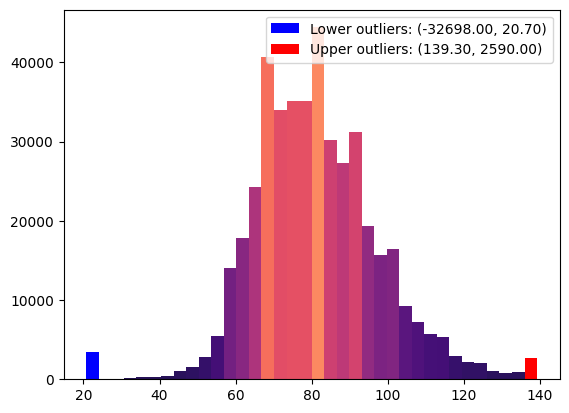

In [ ]:
adb.outliers_histogram(data=mean_abp['value'].dropna(), bins=36).show()


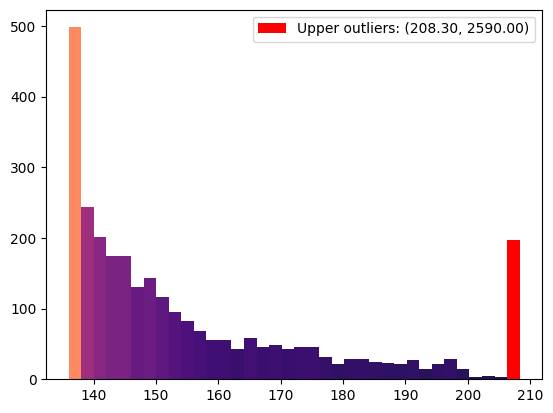

In [ ]:
adb.outliers_histogram(data=mean_abp.loc[mean_abp['value'] > 135, 'value'], bins=36).show()


In [ ]:
#remove extreme outliers, most likely data entry errors or measurement errors
mean_abp.loc[(mean_abp['value'] > 165), 'value'] = np.NaN
mean_abp.loc[(mean_abp['value'] <= 30), 'value'] = np.NaN
mean_abp = mean_abp.dropna()

In [ ]:
#use mean_abp 'cleansed' dataframe
sofa_cardiovascular_map = mean_abp.groupby(['admissionid', 'itemid', 'item']).agg(
        lowest_mean_abp=pd.NamedAgg(column='value', aggfunc='min')
    ).reset_index()
sofa_cardiovascular_map.head()

,admissionid,itemid,item,lowest_mean_abp
0,0,6642,ABP gemiddeld,68.0
1,1,6642,ABP gemiddeld,59.0
2,2,6642,ABP gemiddeld,64.0
3,3,6642,ABP gemiddeld,91.0
4,4,6642,ABP gemiddeld,62.0


In [ ]:
#combine the scores from MAP and cardiovascular medication
sofa_cardiovascular = pd.concat([sofa_cardiovascular_map, sofa_cardiovascular_meds], sort=False).sort_values(by='admissionid')
sofa_cardiovascular.head()

,admissionid,itemid,item,lowest_mean_abp,total_duration,max_gamma,sofa_cardiovascular_score
0,0,6642,ABP gemiddeld,68.0,<NA>,NaN,NaN
1,1,6642,ABP gemiddeld,59.0,<NA>,NaN,NaN
0,1,7179,Dopamine (Inotropin),NaN,301,1.666667,2.0
1,2,7229,Noradrenaline (Norepinefrine),NaN,89,0.125000,4.0
2,2,6642,ABP gemiddeld,64.0,<NA>,NaN,NaN


In [ ]:
#calculate SOFA cardiovascular score:
sofa_cardiovascular_map.loc[:,'sofa_cardiovascular_score'] = 0
#MAP < 70
sofa_cardiovascular_map.loc[(sofa_cardiovascular_map['lowest_mean_abp'] < 70), 'sofa_cardiovascular_score'] = 1

sofa_cardiovascular_map.head()

,admissionid,itemid,item,lowest_mean_abp,sofa_cardiovascular_score
0,0,6642,ABP gemiddeld,68.0,1
1,1,6642,ABP gemiddeld,59.0,1
2,2,6642,ABP gemiddeld,64.0,1
3,3,6642,ABP gemiddeld,91.0,0
4,4,6642,ABP gemiddeld,62.0,1


In [ ]:
#combine the scores from MAP and cardiovascular medication
sofa_cardiovascular = pd.concat([sofa_cardiovascular_map, sofa_cardiovascular_meds], sort=False).sort_values(by='admissionid')
sofa_cardiovascular.head()

,admissionid,itemid,item,lowest_mean_abp,sofa_cardiovascular_score,total_duration,max_gamma
0,0,6642,ABP gemiddeld,68.0,1,<NA>,NaN
1,1,6642,ABP gemiddeld,59.0,1,<NA>,NaN
0,1,7179,Dopamine (Inotropin),NaN,2,301,1.666667
1,2,7229,Noradrenaline (Norepinefrine),NaN,4,89,0.125000
2,2,6642,ABP gemiddeld,64.0,1,<NA>,NaN


In [ ]:
sofa_cardiovascular_to_merge = sofa_cardiovascular[['admissionid', "sofa_cardiovascular_score"]]
sofa_cardiovascular_to_merge = sofa_cardiovascular_to_merge.groupby('admissionid').agg(max)

In [ ]:
sofa_cardiovascular_to_merge

,sofa_cardiovascular_score
admissionid,
0,1
1,2
2,4
3,0
4,2
...,...
23548,4
23549,3
23550,1


In [ ]:
admissions_master=left_join(admissions_master, sofa_cardiovascular_to_merge)


In [ ]:
%%bigquery  sofa_cns

WITH gcs_components AS (
    SELECT
        eyes.admissionid,
        --eyes.itemid,
        --eyes.item,
        --eyes.value,
        --eyes.valueid,
        CASE eyes.itemid
            WHEN 6732 THEN 5 - eyes.valueid     --Actief openen van de ogen
            WHEN 13077 THEN eyes.valueid        --A_Eye
            WHEN 14470 THEN eyes.valueid - 4    --RA_Eye
            WHEN 16628 THEN eyes.valueid - 4    --MCA_Eye
            WHEN 19635 THEN eyes.valueid - 4    --E_EMV_NICE_24uur
            WHEN 19638 THEN eyes.valueid - 8    --E_EMV_NICE_Opname
        END AS eyes_score,
        --motor.value,
        --motor.valueid,
        CASE motor.itemid
            WHEN 6734 THEN 7 - motor.valueid    --Beste motore reactie van de armen
            WHEN 13072 THEN motor.valueid       --A_Motoriek
            WHEN 14476 THEN motor.valueid - 6   --RA_Motoriek
            WHEN 16634 THEN motor.valueid - 6   --MCA_Motoriek
            WHEN 19636 THEN motor.valueid - 6   --M_EMV_NICE_24uur
            WHEN 19639 THEN motor.valueid - 12  --M_EMV_NICE_Opname
        END AS motor_score,
        --verbal.value,
        --verbal.valueid,
        CASE verbal.itemid
            WHEN 6735 THEN 6 - verbal.valueid   --Beste verbale reactie
            WHEN 13066 THEN verbal.valueid      --A_Verbal
            WHEN 14482 THEN verbal.valueid - 5  --RA_Verbal
            WHEN 16640 THEN verbal.valueid - 5  --MCA_Verbal
            WHEN 19637 THEN verbal.valueid - 9 --V_EMV_NICE_24uur
            WHEN 19640 THEN verbal.valueid - 15 --V_EMV_NICE_Opname
        END AS verbal_score,
        eyes.registeredby,
        (eyes.measuredat - a.admittedat)/(1000*60) AS time
    FROM listitems eyes
    LEFT JOIN admissions a ON
        eyes.admissionid = a.admissionid
    LEFT JOIN listitems motor ON
        eyes.admissionid = motor.admissionid AND
        eyes.measuredat = motor.measuredat AND
        motor.itemid IN (
            6734, --Beste motore reactie van de armen
            13072, --A_Motoriek
            14476, --RA_Motoriek
            16634, --MCA_Motoriek
            19636, --M_EMV_NICE_24uur
            19639 --M_EMV_NICE_Opname
        )
    LEFT JOIN listitems verbal ON
        eyes.admissionid = verbal.admissionid AND
        eyes.measuredat = verbal.measuredat AND
        verbal.itemid IN (
            6735, --Beste verbale reactie
            13066, --A_Verbal
            14482, --RA_Verbal
            16640, --MCA_Verbal
            19637, --V_EMV_NICE_24uur
            19640 --V_EMV_NICE_Opname
        )
    WHERE eyes.itemid IN (
        6732, --Actief openen van de ogen
        13077, --A_Eye
        14470, --RA_Eye
        16628, --MCA_Eye
        19635, --E_EMV_NICE_24uur
        19638 --E_EMV_NICE_Opname
        )
    -- measurements within 24 hours of ICU stay:
    AND (eyes.measuredat - a.admittedat) <= 1000*60*60*24 AND (eyes.measuredat - a.admittedat) >= 0
), gcs AS (
    SELECT *,
        eyes_score + motor_score + (
            CASE
                WHEN verbal_score < 1 THEN 1
                ELSE verbal_score
            END
        ) AS gcs_score
    FROM gcs_components
), gcs_prioritized AS (
    SELECT *,
        ROW_NUMBER() OVER(
            PARTITION BY admissionid
            ORDER BY --orders by discipline
                CASE registeredby
                    WHEN 'ICV_Medisch Staflid' THEN 1
                    WHEN 'ICV_Medisch' THEN 2
                    WHEN 'ANES_Anesthesiologie'THEN 3
                    WHEN 'ICV_Physician assistant' THEN 4
                    WHEN 'ICH_Neurochirurgie'THEN 5
                    WHEN 'ICV_IC-Verpleegkundig' THEN 6
                    WHEN 'ICV_MC-Verpleegkundig' THEN 7
                    ELSE 8
                END, gcs_score
        ) AS priority
    FROM gcs
    ORDER BY admissionid, gcs_score ASC
)
SELECT *
FROM gcs_prioritized
WHERE priority = 1



Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
sofa_cns = sofa_cns.groupby(['admissionid']).agg(
        min_gcs=pd.NamedAgg(column='gcs_score', aggfunc='min')
    ).reset_index()
sofa_cns.head()

,admissionid,min_gcs
0,0,15
1,1,15
2,2,15
3,4,3
4,5,15


In [ ]:
#calculate SOFA Central nervous system score:
sofa_cns.loc[:,'sofa_cns_score'] = 0
sofa_cns.loc[(sofa_cns['min_gcs'] >= 13) & (sofa_cns['min_gcs'] < 15), 'sofa_cns_score'] = 1
sofa_cns.loc[(sofa_cns['min_gcs'] >= 10) & (sofa_cns['min_gcs'] < 13), 'sofa_cns_score'] = 2
sofa_cns.loc[(sofa_cns['min_gcs'] >= 6) & (sofa_cns['min_gcs'] < 10), 'sofa_cns_score'] = 3
sofa_cns.loc[(sofa_cns['min_gcs'] < 6), 'sofa_cns_score'] = 4
sofa_cns.head()

,admissionid,min_gcs,sofa_cns_score
0,0,15,0
1,1,15,0
2,2,15,0
3,4,3,4
4,5,15,0


In [ ]:
sofa_cns_tomerge =  sofa_cns[["admissionid", "sofa_cns_score"]]

In [ ]:
admissions_master = left_join(admissions_master, sofa_cns_tomerge)

In [ ]:
%%bigquery sofa_renal_urine_output
SELECT
    n.admissionid,
    n.itemid,
    n.item,
    n.value,
    n.registeredby,
    (n.measuredat - a.admittedat)/(1000*60) AS time
FROM numericitems n
LEFT JOIN admissions a ON
    n.admissionid = a.admissionid
WHERE n.itemid IN (
    8794, --UrineCAD
    8796, --UrineSupraPubis
    8798, --UrineSpontaan
    8800, --UrineIncontinentie
    8803, --UrineUP
    10743, --Nefrodrain li Uit
    10745, --Nefrodrain re Uit
    19921, --UrineSplint Li
    19922 --UrineSplint Re
    )
-- measurements within 24 hours of ICU stay (use 30 minutes before admission to allow for time differences):
AND (n.measuredat - a.admittedat) <= 1000*60*60*24 AND (n.measuredat - a.admittedat) >= 0



Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
sofa_renal_urine_output=sofa_renal_urine_output
sofa_renal_urine_output

,admissionid,itemid,item,value,registeredby,time
0,7,19922,UrineSplint Re,200.0,ICV_MC-Verpleegkundig,678.0
1,7,19922,UrineSplint Re,100.0,ICV_MC-Verpleegkundig,918.0
2,7,19922,UrineSplint Re,75.0,ICV_MC-Verpleegkundig,1038.0
3,7,19922,UrineSplint Re,140.0,ICV_MC-Verpleegkundig,318.0
4,7,19922,UrineSplint Re,120.0,ICV_MC-Verpleegkundig,798.0
...,...,...,...,...,...,...
332843,22795,8794,UrineCAD,575.0,ICV_MC-Verpleegkundig,18.0
332844,22510,8794,UrineCAD,575.0,ICV_MC-Verpleegkundig,328.0
332845,21303,8794,UrineCAD,575.0,ICV_IC-Verpleegkundig,1219.0
332846,23293,8794,UrineCAD,575.0,ICV_IC-Verpleegkundig,252.0


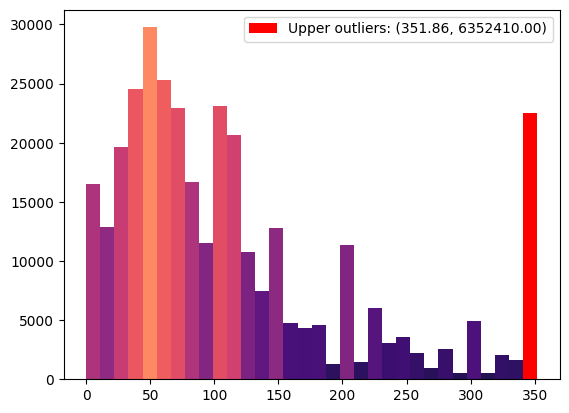

In [ ]:
adb.outliers_histogram(data=sofa_renal_urine_output['value'], bins=32).show()


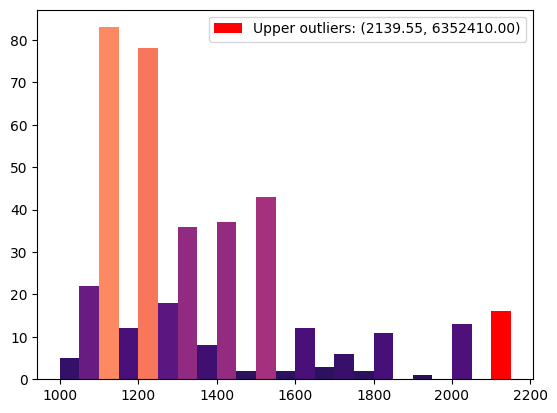

In [ ]:
adb.outliers_histogram(data=sofa_renal_urine_output.loc[(sofa_renal_urine_output['value'] > 1000), 'value']).show()


In [ ]:
#looking at the data it's relevatively easy to spot most lab collection errors (i.e. single outliers between relatively
# normal values
# TO DO: algorithm to remove these errors, but not 'real' outliers
sofa_renal_urine_output.loc[sofa_renal_urine_output['admissionid'].isin(
    sofa_renal_urine_output.loc[(sofa_renal_urine_output['value'] > 2500), 'admissionid'])
             ].sort_values(by='admissionid').head(5)

,admissionid,itemid,item,value,registeredby,time
145219,4170,8794,UrineCAD,120.0,ICV_MC-Verpleegkundig,683.0
112776,4170,8794,UrineCAD,320.0,ICV_IC-Verpleegkundig,203.0
112929,4170,8794,UrineCAD,320.0,ICV_IC-Verpleegkundig,83.0
141041,4170,8794,UrineCAD,380.0,ICV_IC-Verpleegkundig,143.0
142510,4170,8794,UrineCAD,2550.0,ICV_IC-Verpleegkundig,23.0


In [ ]:
#probably decimal error when entering volumes > 2500
sofa_renal_urine_output.loc[(sofa_renal_urine_output['value'] > 2500), 'value'] = sofa_renal_urine_output['value']/10

In [ ]:
#remove extreme outliers, most likely data entry error)
sofa_renal_urine_output.loc[(sofa_renal_urine_output['value'] > 4500), 'value'] = np.NaN
sofa_renal_urine_output = sofa_renal_urine_output.dropna()

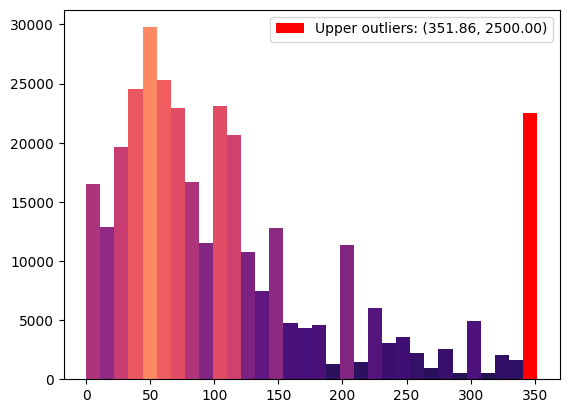

In [ ]:
adb.outliers_histogram(data=sofa_renal_urine_output['value'], bins=32).show()


In [ ]:
#get urine output per 24 hours
sofa_renal_daily_urine_output = sofa_renal_urine_output.groupby(['admissionid']).agg(
        daily_urine_output=pd.NamedAgg(column='value', aggfunc='sum')
    ).reset_index()
sofa_renal_daily_urine_output.head()

,admissionid,daily_urine_output
0,0,2005.0
1,1,2540.0
2,2,1785.0
3,3,2301.0
4,4,1155.0


In [ ]:
#calculate SOFA renal score for urine output:
sofa_renal_daily_urine_output.loc[:,'sofa_renal_score'] = 0

#urine output < 500 ml/day
sofa_renal_daily_urine_output.loc[(
    ((sofa_renal_daily_urine_output['daily_urine_output'] < 500) &
     (sofa_renal_daily_urine_output['daily_urine_output'] > 200))
), 'sofa_renal_score'] = 3

#urine output < 200 ml/day
sofa_renal_daily_urine_output.loc[(
    ((sofa_renal_daily_urine_output['daily_urine_output'] < 200))
), 'sofa_renal_score'] = 4

sofa_renal_daily_urine_output.head()

,admissionid,daily_urine_output,sofa_renal_score
0,0,2005.0,0
1,1,2540.0,0
2,2,1785.0,0
3,3,2301.0,0
4,4,1155.0,0


In [ ]:
%%bigquery creatinine

WITH baseline AS (
    SELECT n.admissionid,
    MIN(n.value) AS baseline_creatinine
    FROM numericitems n
    LEFT JOIN admissions a ON
        n.admissionid = a.admissionid
    WHERE itemid IN (
        6836, --Kreatinine Âµmol/l (erroneously documented as Âµmol)
        9941, --Kreatinine (bloed) Âµmol/l
        14216 --KREAT enzym. (bloed) Âµmol/l
    ) AND
    --search upto 1 year before admission
    (n.measuredat - a.admittedat)/(60*60*1000) > -(365*24) AND (n.measuredat - a.admittedat) < (24*60*60*1000)
    GROUP BY n.admissionid
),
max_creat AS (
    SELECT n.admissionid,
    MAX(n.value) AS max_creatinine_7days
    FROM numericitems n
    LEFT JOIN admissions a ON
        n.admissionid = a.admissionid
    WHERE itemid IN (
        6836, --Kreatinine Âµmol/l (erroneously documented as Âµmol)
        9941, --Kreatinine (bloed) Âµmol/l
        14216 --KREAT enzym. (bloed) Âµmol/l
    ) AND
    --within 7 days of admission
    (n.measuredat - a.admittedat) > 0 AND (n.measuredat - a.admittedat) < (7*24*60*60*1000)
    GROUP BY n.admissionid
)
SELECT
    n.admissionid,
    n.itemid,
    n.item,
    n.value,
    n.registeredby,
    CASE
        WHEN UPPER(n.registeredby) NOT LIKE UPPER('%Systeem%') THEN TRUE
        ELSE FALSE
    END AS manual_entry,
    (n.measuredat - a.admittedat)/(1000*60) AS time,
    b.baseline_creatinine,
    m.max_creatinine_7days,
    CASE
        -- AKI definition: 3 fold increase:
        WHEN baseline_creatinine > 0 AND m.max_creatinine_7days/baseline_creatinine > 3 THEN TRUE
        -- AKI definition: increase to >= 354 umol/l AND at least 44 umol/l increase:
        WHEN max_creatinine_7days >= 354 AND max_creatinine_7days - baseline_creatinine >= 44 THEN TRUE
        ELSE FALSE
    END AS acute_renal_failure
FROM numericitems n
LEFT JOIN admissions a ON
    n.admissionid = a.admissionid
LEFT JOIN baseline b ON -- get the baseline kreat (before admission)
    n.admissionid = b.admissionid
LEFT JOIN max_creat m ON --get the highest within a week of admission
    n.admissionid = m.admissionid
WHERE n.itemid IN (
    6836, --Kreatinine Âµmol/l (erroneously documented as Âµmol)
    9941, --Kreatinine (bloed) Âµmol/l
    14216 --KREAT enzym. (bloed) Âµmol/l
    )
-- measurements within 24 hours of ICU stay (use 30 minutes before admission to allow for time differences):
AND (n.measuredat - a.admittedat) <= 1000*60*60*24 AND (n.measuredat - a.admittedat) >= -(1000*60*30)


Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
creatinine=creatinine
creatinine


,admissionid,itemid,item,value,registeredby,manual_entry,time,baseline_creatinine,max_creatinine_7days,acute_renal_failure
0,11520,6836,Kreatinine,88.0,ICV_IC-Verpleegkundig,True,196.0,80.0,88.0,False
1,16384,6836,Kreatinine,122.0,ICV_IC-Verpleegkundig,True,13.0,83.0,122.0,False
2,8705,6836,Kreatinine,84.0,ICV_IC-Verpleegkundig,True,336.0,74.0,125.0,False
3,8705,6836,Kreatinine,125.0,ICV_IC-Verpleegkundig,True,-24.0,74.0,125.0,False
4,8705,6836,Kreatinine,111.0,ICV_IC-Verpleegkundig,True,36.0,74.0,125.0,False
...,...,...,...,...,...,...,...,...,...,...
48153,15637,9941,Kreatinine (bloed),799.0,Systeem,False,793.0,622.0,799.0,True
48154,14903,9941,Kreatinine (bloed),895.0,Systeem,False,890.0,762.0,895.0,True
48155,15528,9941,Kreatinine (bloed),1214.0,Systeem,False,544.0,766.0,1371.0,True
48156,17346,9941,Kreatinine (bloed),1215.0,Systeem,False,92.0,769.0,1215.0,True


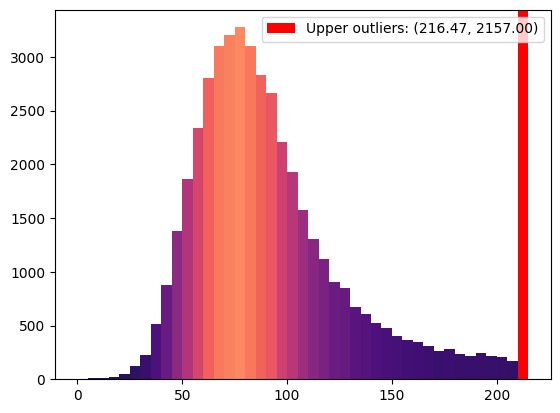

In [ ]:
adb.outliers_histogram(data=creatinine['value']).show()


In [ ]:
#looking at the data it's relevatively easy to spot most lab collection errors (i.e. single outliers between relatively
# normal values
# TO DO: algorithm to remove these errors, but not 'real' outliers
creatinine.loc[creatinine['admissionid'].isin(
    creatinine.loc[(creatinine['value']> 1000) & (creatinine['manual_entry'] == True), 'admissionid'])
             ].sort_values(by='admissionid')

,admissionid,itemid,item,value,registeredby,manual_entry,time,baseline_creatinine,max_creatinine_7days,acute_renal_failure
1222,5819,6836,Kreatinine,385.0,ICV_Medisch Staflid,True,1392.0,385.0,1013.0,True
1223,5819,6836,Kreatinine,1013.0,ICV_IC-Verpleegkundig,True,12.0,385.0,1013.0,True
1224,5819,6836,Kreatinine,680.0,ICV_IC-Verpleegkundig,True,672.0,385.0,1013.0,True
47036,7637,9941,Kreatinine (bloed),1078.0,Systeem,False,1111.0,1078.0,2157.0,True
47038,7637,9941,Kreatinine (bloed),2157.0,ICV_Medisch Staflid,True,1.0,1078.0,2157.0,True
47951,7637,9941,Kreatinine (bloed),1144.0,Systeem,False,718.0,1078.0,2157.0,True
47953,7637,9941,Kreatinine (bloed),1720.0,Systeem,False,156.0,1078.0,2157.0,True
15972,13151,9941,Kreatinine (bloed),1291.0,Systeem,False,70.0,1291.0,1355.0,True
15973,13151,9941,Kreatinine (bloed),1355.0,ICV_IC-Verpleegkundig,True,409.0,1291.0,1355.0,True


In [ ]:
#remove extreme outliers, most likely data entry errors (manual_entry = True)
creatinine.loc[(creatinine['value'] < 30) & (creatinine['manual_entry'] == True), 'value'] = np.NaN
creatinine = creatinine.dropna(subset=['value'])

In [ ]:
#get highest creatinine per 24 hours
#use creatinine 'cleansed' dataframe from APACHE score
sofa_renal_creatinine = creatinine.groupby(['admissionid']).agg(
        max_creatinine=pd.NamedAgg(column='value', aggfunc='max')
    ).reset_index()
sofa_renal_creatinine.head()

,admissionid,max_creatinine
0,0,86.0
1,1,91.0
2,2,81.0
3,3,113.0
4,4,98.0


In [ ]:
#calculate SOFA renal score for creatinine:
sofa_renal_creatinine.loc[:,'sofa_renal_score'] = 0

#creatinine 110-170 umol/l
sofa_renal_creatinine.loc[(
    ((sofa_renal_creatinine['max_creatinine'] >= 110) &
     (sofa_renal_creatinine['max_creatinine'] < 171))
), 'sofa_renal_score'] = 1

#creatinine 171-299 umol/l
sofa_renal_creatinine.loc[(
    ((sofa_renal_creatinine['max_creatinine'] >= 171) &
     (sofa_renal_creatinine['max_creatinine'] < 300))
), 'sofa_renal_score'] = 2

#creatinine 300-440 umol/l
sofa_renal_creatinine.loc[(
    ((sofa_renal_creatinine['max_creatinine'] >= 300) &
     (sofa_renal_creatinine['max_creatinine'] <= 440))
), 'sofa_renal_score'] = 3

#creatinine >440 umol/l
sofa_renal_creatinine.loc[(
    ((sofa_renal_creatinine['max_creatinine'] > 440))
), 'sofa_renal_score'] = 4

sofa_renal_creatinine.head()

,admissionid,max_creatinine,sofa_renal_score
0,0,86.0,0
1,1,91.0,0
2,2,81.0,0
3,3,113.0,1
4,4,98.0,0


In [ ]:
#combine the scores from creatinine and urine output
sofa_renal = pd.concat([sofa_renal_creatinine, sofa_renal_daily_urine_output], sort=False).sort_values(by='admissionid')
sofa_renal.head()

,admissionid,max_creatinine,sofa_renal_score,daily_urine_output
0,0,86.0,0,NaN
0,0,NaN,0,2005.0
1,1,91.0,0,NaN
1,1,NaN,0,2540.0
2,2,81.0,0,NaN


In [ ]:
sofa_renal_tomerge = sofa_renal[["admissionid", "sofa_renal_score"]]
sofa_renal_tomerge = sofa_renal_tomerge.groupby('admissionid').agg(max)

In [ ]:
admissions_master=left_join(admissions_master, sofa_renal_tomerge )

In [ ]:
admissions_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23106 entries, 0 to 23105
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   admissionid                23106 non-null  Int64  
 1   patientid                  23106 non-null  Int64  
 2   location                   23106 non-null  object 
 3   specialty                  21805 non-null  object 
 4   urgency                    23106 non-null  Int64  
 5   mortality                  23106 non-null  int64  
 6   lengthofstay               23106 non-null  Int64  
 7   los_days                   23106 non-null  Int64  
 8   age_number                 23106 non-null  int64  
 9   BMI                        21624 non-null  float64
 10  sofa_respiration_score     20189 non-null  float64
 11  platelets                  22394 non-null  float64
 12  sofa_coagulation_score     22394 non-null  float64
 13  bilirubin                  23106 non-null  flo

In [ ]:
admissions_master["sofa_total"] = admissions_master["sofa_respiration_score"] + admissions_master["sofa_liver_score"] + admissions_master["sofa_coagulation_score"] + admissions_master["sofa_cardiovascular_score"] + admissions_master["sofa_cns_score"] + admissions_master["sofa_renal_score"]

In [ ]:
#reason_for_admission
%%bigquery reason_for_admission
WITH diagnosis_groups AS (
    SELECT admissionid,
        item,
        CASE
            WHEN itemid IN (
                18669, --NICE APACHEII diagnosen
                18671 --NICE APACHEIV diagnosen
            )
            THEN SPLIT(value, ' - ')[SAFE_ORDINAL(1)]
            -- 'e.g. 'Non-operative cardiovascular - Anaphylaxis' -> Non-operative cardiovascular
            ELSE value
        END as diagnosis_group,
        valueid as diagnosis_group_id,
        ROW_NUMBER() OVER(PARTITION BY admissionid
        ORDER BY
            CASE --prefer NICE > APACHE IV > II > D
                WHEN itemid = 18671 THEN 6 --NICE APACHEIV diagnosen
                WHEN itemid = 18669 THEN 5 --NICE APACHEII diagnosen
                WHEN itemid = 16997 THEN 4 --APACHE IV Groepen
                WHEN itemid = 18588 THEN 3 --Apache II Hoofdgroep
                WHEN itemid = 13110 THEN 2 --D_Hoofdgroep
                WHEN itemid = 16651 THEN 1 --DMC_Hoofdgroep, Medium Care
            END DESC,
            updatedat DESC, --prefer diagnosis_group with most recent update time
            measuredat DESC --prefer diagnosis_group with most recent session/form time
            ) AS rownum
    FROM listitems
    WHERE itemid IN (
        --MAIN GROUP - LEVEL 0
        13110, --D_Hoofdgroep
        16651, --DMC_Hoofdgroep, Medium Care

        18588, --Apache II Hoofdgroep
        16997, --APACHE IV Groepen

        18669, --NICE APACHEII diagnosen
        18671 --NICE APACHEIV diagnosen
    )
),diagnosis_subgroups AS (
    SELECT admissionid,
        item,
        value as diagnosis_subgroup,
        valueid as diagnosis_subgroup_id,
        ROW_NUMBER() OVER(PARTITION BY admissionid
        ORDER BY
            updatedat DESC, --prefer diagnosis_subgroup with most recent update time
            measuredat DESC --prefer diagnosis_subgroup with most recent session/form time
            ) AS rownum
    FROM listitems
    WHERE itemid IN (
        --SUB GROUP - LEVEL 1
        13111, --D_Subgroep_Thoraxchirurgie
        16669, --DMC_Subgroep_Thoraxchirurgie
        13112, --D_Subgroep_Algemene chirurgie
        16665, --DMC_Subgroep_Algemene chirurgie
        13113, --D_Subgroep_Neurochirurgie
        16667, --DMC_Subgroep_Neurochirurgie
        13114, --D_Subgroep_Neurologie
        16668, --DMC_Subgroep_Neurologie
        13115, --D_Subgroep_Interne geneeskunde
        16666 --DMC_Subgroep_Interne geneeskunde
    )
), diagnoses AS (
    SELECT admissionid,
        item,
        CASE
            WHEN itemid IN (
                18669, --NICE APACHEII diagnosen
                18671 --NICE APACHEIV diagnosen
            )
            THEN SPLIT(value, ' - ')[SAFE_ORDINAL(2)]
            -- 'e.g. 'Non-operative cardiovascular - Anaphylaxis' -> Anaphylaxis
            ELSE value
        END as diagnosis,
        CASE
            WHEN itemid IN (
                --SURGICAL
                13116, --D_Thoraxchirurgie_CABG en Klepchirurgie
                16671, --DMC_Thoraxchirurgie_CABG en Klepchirurgie
                13117, --D_Thoraxchirurgie_Cardio anders
                16672, --DMC_Thoraxchirurgie_Cardio anders
                13118, --D_Thoraxchirurgie_Aorta chirurgie
                16670, --DMC_Thoraxchirurgie_Aorta chirurgie
                13119, --D_Thoraxchirurgie_Pulmonale chirurgie
                16673, --DMC_Thoraxchirurgie_Pulmonale chirurgie

                --Not surgical: 13141, --D_Algemene chirurgie_Algemeen
                --Not surgical: 16642, --DMC_Algemene chirurgie_Algemeen
                13121, --D_Algemene chirurgie_Buikchirurgie
                16643, --DMC_Algemene chirurgie_Buikchirurgie
                13123, --D_Algemene chirurgie_Endocrinologische chirurgie
                16644, --DMC_Algemene chirurgie_Endocrinologische chirurgie
                13145, --D_Algemene chirurgie_KNO/Overige
                16645, --DMC_Algemene chirurgie_KNO/Overige
                13125, --D_Algemene chirurgie_Orthopedische chirurgie
                16646, --DMC_Algemene chirurgie_Orthopedische chirurgie
                13122, --D_Algemene chirurgie_Transplantatie chirurgie
                16647, --DMC_Algemene chirurgie_Transplantatie chirurgie
                13124, --D_Algemene chirurgie_Trauma
                16648, --DMC_Algemene chirurgie_Trauma
                13126, --D_Algemene chirurgie_Urogenitaal
                16649, --DMC_Algemene chirurgie_Urogenitaal
                13120, --D_Algemene chirurgie_Vaatchirurgie
                16650, --DMC_Algemene chirurgie_Vaatchirurgie

                13128, --D_Neurochirurgie _Vasculair chirurgisch
                16661, --DMC_Neurochirurgie _Vasculair chirurgisch
                13129, --D_Neurochirurgie _Tumor chirurgie
                16660, --DMC_Neurochirurgie _Tumor chirurgie
                13130, --D_Neurochirurgie_Overige
                16662, --DMC_Neurochirurgie_Overige

                18596, --Apache II Operatief  Gastr-intenstinaal
                18597, --Apache II Operatief Cardiovasculair
                18598, --Apache II Operatief Hematologisch
                18599, --Apache II Operatief Metabolisme
                18600, --Apache II Operatief Neurologisch
                18601, --Apache II Operatief Renaal
                18602, --Apache II Operatief Respiratoir

                17008, --APACHEIV Post-operative cardiovascular
                17009, --APACHEIV Post-operative gastro-intestinal
                17010, --APACHEIV Post-operative genitourinary
                17011, --APACHEIV Post-operative hematology
                17012, --APACHEIV Post-operative metabolic
                17013, --APACHEIV Post-operative musculoskeletal /skin
                17014, --APACHEIV Post-operative neurologic
                17015, --APACHEIV Post-operative respiratory
                17016, --APACHEIV Post-operative transplant
                17017 --APACHEIV Post-operative trauma

            ) THEN 1
            WHEN itemid = 18669 AND valueid BETWEEN 1 AND 26 THEN 1 --NICE APACHEII diagnosen
            WHEN itemid = 18671 AND valueid BETWEEN 222 AND 452 THEN 1 --NICE APACHEIV diagnosen
            ELSE 0
        END AS surgical,
        valueid as diagnosis_id,
        CASE
                WHEN itemid = 18671 THEN 'NICE APACHE IV'
                WHEN itemid = 18669 THEN 'NICE APACHE II'
                WHEN itemid BETWEEN 16998 AND 17017 THEN 'APACHE IV'
                WHEN itemid BETWEEN 18589 AND 18602 THEN 'APACHE II'
                WHEN itemid BETWEEN 13116 AND 13145 THEN 'Legacy ICU'
                WHEN itemid BETWEEN 16642 AND 16673 THEN 'Legacy MCU'
        END AS diagnosis_type,
        ROW_NUMBER() OVER(PARTITION BY admissionid
        ORDER BY
            CASE --prefer NICE > APACHE IV > II > D
                WHEN itemid = 18671 THEN 6 --NICE APACHEIV diagnosen
                WHEN itemid = 18669 THEN 5 --NICE APACHEII diagnosen
                WHEN itemid BETWEEN 16998 AND 17017 THEN 4 --APACHE IV diagnosis
                WHEN itemid BETWEEN 18589 AND 18602 THEN 3 --APACHE II diagnosis
                WHEN itemid BETWEEN 13116 AND 13145 THEN 2 --D diagnosis ICU
                WHEN itemid BETWEEN 16642 AND 16673 THEN 1 --DMC diagnosis Medium Care
            END DESC,
            updatedat DESC, --prefer diagnosis with most recent update time
            measuredat DESC, --prefer diagnosis with most recent session/form time
            valueid ASC, --force lower valued diagnoses to prevent arbitrary sorting for rare cases
            itemid ASC --force lower valued diagnosis groups to prevent arbitrary sorting for rare cases
            ) AS rownum
    FROM listitems
    WHERE itemid IN (
        -- Diagnosis - LEVEL 2
        --SURGICAL
        13116, --D_Thoraxchirurgie_CABG en Klepchirurgie
        16671, --DMC_Thoraxchirurgie_CABG en Klepchirurgie
        13117, --D_Thoraxchirurgie_Cardio anders
        16672, --DMC_Thoraxchirurgie_Cardio anders
        13118, --D_Thoraxchirurgie_Aorta chirurgie
        16670, --DMC_Thoraxchirurgie_Aorta chirurgie
        13119, --D_Thoraxchirurgie_Pulmonale chirurgie
        16673, --DMC_Thoraxchirurgie_Pulmonale chirurgie

        13141, --D_Algemene chirurgie_Algemeen
        16642, --DMC_Algemene chirurgie_Algemeen
        13121, --D_Algemene chirurgie_Buikchirurgie
        16643, --DMC_Algemene chirurgie_Buikchirurgie
        13123, --D_Algemene chirurgie_Endocrinologische chirurgie
        16644, --DMC_Algemene chirurgie_Endocrinologische chirurgie
        13145, --D_Algemene chirurgie_KNO/Overige
        16645, --DMC_Algemene chirurgie_KNO/Overige
        13125, --D_Algemene chirurgie_Orthopedische chirurgie
        16646, --DMC_Algemene chirurgie_Orthopedische chirurgie
        13122, --D_Algemene chirurgie_Transplantatie chirurgie
        16647, --DMC_Algemene chirurgie_Transplantatie chirurgie
        13124, --D_Algemene chirurgie_Trauma
        16648, --DMC_Algemene chirurgie_Trauma
        13126, --D_Algemene chirurgie_Urogenitaal
        16649, --DMC_Algemene chirurgie_Urogenitaal
        13120, --D_Algemene chirurgie_Vaatchirurgie
        16650, --DMC_Algemene chirurgie_Vaatchirurgie

        13128, --D_Neurochirurgie _Vasculair chirurgisch
        16661, --DMC_Neurochirurgie _Vasculair chirurgisch
        13129, --D_Neurochirurgie _Tumor chirurgie
        16660, --DMC_Neurochirurgie _Tumor chirurgie
        13130, --D_Neurochirurgie_Overige
        16662, --DMC_Neurochirurgie_Overige

        18596, --Apache II Operatief  Gastr-intenstinaal
        18597, --Apache II Operatief Cardiovasculair
        18598, --Apache II Operatief Hematologisch
        18599, --Apache II Operatief Metabolisme
        18600, --Apache II Operatief Neurologisch
        18601, --Apache II Operatief Renaal
        18602, --Apache II Operatief Respiratoir

        17008, --APACHEIV Post-operative cardiovascular
        17009, --APACHEIV Post-operative gastro-intestinal
        17010, --APACHEIV Post-operative genitourinary
        17011, --APACHEIV Post-operative hematology
        17012, --APACHEIV Post-operative metabolic
        17013, --APACHEIV Post-operative musculoskeletal /skin
        17014, --APACHEIV Post-operative neurologic
        17015, --APACHEIV Post-operative respiratory
        17016, --APACHEIV Post-operative transplant
        17017, --APACHEIV Post-operative trauma

        --MEDICAL
        13133, --D_Interne Geneeskunde_Cardiovasculair
        16653, --DMC_Interne Geneeskunde_Cardiovasculair
        13134, --D_Interne Geneeskunde_Pulmonaal
        16658, --DMC_Interne Geneeskunde_Pulmonaal
        13135, --D_Interne Geneeskunde_Abdominaal
        16652, --DMC_Interne Geneeskunde_Abdominaal
        13136, --D_Interne Geneeskunde_Infectieziekten
        16655, --DMC_Interne Geneeskunde_Infectieziekten
        13137, --D_Interne Geneeskunde_Metabool
        16656, --DMC_Interne Geneeskunde_Metabool
        13138, --D_Interne Geneeskunde_Renaal
        16659, --DMC_Interne Geneeskunde_Renaal
        13139, --D_Interne Geneeskunde_Hematologisch
        16654, --DMC_Interne Geneeskunde_Hematologisch
        13140, --D_Interne Geneeskunde_Overige
        16657, --DMC_Interne Geneeskunde_Overige

        13131, --D_Neurologie_Vasculair neurologisch
        16664, --DMC_Neurologie_Vasculair neurologisch
        13132, --D_Neurologie_Overige
        16663, --DMC_Neurologie_Overige
        13127, --D_KNO/Overige

        18589, --Apache II Non-Operatief Cardiovasculair
        18590, --Apache II Non-Operatief Gastro-intestinaal
        18591, --Apache II Non-Operatief Hematologisch
        18592, --Apache II Non-Operatief Metabolisme
        18593, --Apache II Non-Operatief Neurologisch
        18594, --Apache II Non-Operatief Renaal
        18595, --Apache II Non-Operatief Respiratoir

        16998, --APACHE IV Non-operative cardiovascular
        16999, --APACHE IV Non-operative Gastro-intestinal
        17000, --APACHE IV Non-operative genitourinary
        17001, --APACHEIV  Non-operative haematological
        17002, --APACHEIV  Non-operative metabolic
        17003, --APACHEIV Non-operative musculo-skeletal
        17004, --APACHEIV Non-operative neurologic
        17005, --APACHEIV Non-operative respiratory
        17006, --APACHEIV Non-operative transplant
        17007, --APACHEIV Non-operative trauma

        --NICE: surgical/medical combined in same parameter
        18669, --NICE APACHEII diagnosen
        18671 --NICE APACHEIV diagnosen
    )
), sepsis AS (
    SELECT
        admissionid,
        CASE valueid
            WHEN 1 THEN 1 --'Ja'
            WHEN 2 THEN 0 --'Nee'
        END as sepsis_at_admission,
        ROW_NUMBER() OVER(
            PARTITION BY
                admissionid
            ORDER BY
                updatedat DESC, --prefer sepsis diagnosis with most recent update time
                measuredat DESC) AS rownum --prefer sepsis diagnosis with most recent session/form time
    FROM listitems
    WHERE
        itemid = 15808
), sepsis_antibiotics AS ( --non prophylactic antibiotics
    SELECT
        admissionid,
        CASE
            WHEN COUNT(*) > 0 THEN 1
            ELSE 0
        END AS sepsis_antibiotics_bool,
        STRING_AGG(DISTINCT item, '; ') AS sepsis_antibiotics_given
    FROM drugitems
    WHERE
        itemid IN (
            6834, --Amikacine (Amukin)
            6847, --Amoxicilline (Clamoxyl/Flemoxin)
            6871, --Benzylpenicilline (Penicilline)
            6917, --Ceftazidim (Fortum)
            --6919, --Cefotaxim (Claforan) -> prophylaxis
            6948, --Ciprofloxacine (Ciproxin)
            6953, --Rifampicine (Rifadin)
            6958, --Clindamycine (Dalacin)
            7044, --Tobramycine (Obracin)
            --7064, --Vancomycine -> prophylaxis for valve surgery
            7123, --Imipenem (Tienam)
            7185, --Doxycycline (Vibramycine)
            --7187, --Metronidazol (Flagyl) -> often used for GI surgical prophylaxis
            --7208, --Erythromycine (Erythrocine) -> often used for gastroparesis
            7227, --Flucloxacilline (Stafoxil/Floxapen)
            7231, --Fluconazol (Diflucan)
            7232, --Ganciclovir (Cymevene)
            7233, --Flucytosine (Ancotil)
            7235, --Gentamicine (Garamycin)
            7243, --Foscarnet trinatrium (Foscavir)
            7450, --Amfotericine B (Fungizone)
            --7504, --X nader te bepalen --non-stock medication
            8127, --Meropenem (Meronem)
            8229, --Myambutol (ethambutol)
            8374, --Kinine dihydrocloride
            --8375, --Immunoglobuline (Nanogam) -> not anbiotic
            --8394, --Co-Trimoxazol (Bactrimel) -> often prophylactic (unless high dose)
            8547, --Voriconazol(VFEND)
            --9029, --Amoxicilline/Clavulaanzuur (Augmentin) -> often used for ENT surgical prophylaxis
            9030, --Aztreonam (Azactam)
            9047, --Chlooramfenicol
            --9075, --Fusidinezuur (Fucidin) -> prophylaxis
            9128, --Piperacilline (Pipcil)
            9133, --Ceftriaxon (Rocephin)
            --9151, --Cefuroxim (Zinacef) -> often used for GI/transplant surgical prophylaxis
            --9152, --Cefazoline (Kefzol) -> prophylaxis for cardiac surgery
            9458, --Caspofungine
            9542, --Itraconazol (Trisporal)
            --9602, --Tetanusimmunoglobuline -> prophylaxis/not antibiotic
            12398, --Levofloxacine (Tavanic)
            12772, --Amfotericine B lipidencomplex  (Abelcet)
            15739, --Ecalta (Anidulafungine)
            16367, --Research Anidulafungin/placebo
            16368, --Research Caspofungin/placebo
            18675, --Amfotericine B in liposomen (Ambisome )
            19137, --Linezolid (Zyvoxid)
            19764, --Tigecycline (Tygacil)
            19773, --Daptomycine (Cubicin)
            20175 --Colistine
        )
        AND start < 24*60*60*1000 --within 24 hours (to correct for antibiotics administered before ICU)
    GROUP BY admissionid
), other_antibiotics AS ( --'prophylactic' antibiotics that may be used for sepsis
    SELECT
        admissionid,
        CASE
            WHEN COUNT(*) > 0 THEN 1
            ELSE 0
        END AS other_antibiotics_bool,
        STRING_AGG(DISTINCT item, '; ') AS other_antibiotics_given
    FROM drugitems
    WHERE
        itemid IN (
            7064, --Vancomycine -> prophylaxis for valve surgery
            7187, --Metronidazol (Flagyl) -> often used for GI surgical prophylaxis
            8394, --Co-Trimoxazol (Bactrimel) -> often prophylactic (unless high dose)
            9029, --Amoxicilline/Clavulaanzuur (Augmentin) -> often used for ENT surgical prophylaxis
            9151, --Cefuroxim (Zinacef) -> often used for GI surgical prophylaxis
            9152 --Cefazoline (Kefzol) -> prophylaxis
        )
        AND start < 24*60*60*1000 --within 24 hours (to correct for antibiotics administered before ICU)
    GROUP BY admissionid
), cultures AS (
    SELECT
        admissionid,
        CASE
            WHEN COUNT(*) > 0 THEN 1
            ELSE 0
        END AS sepsis_cultures_bool,
        STRING_AGG(DISTINCT item, '; ') AS sepsis_cultures_drawn
    FROM procedureorderitems
    WHERE
        itemid IN (
        --8097, --Sputumkweek afnemen -> often used routinely
        --8418, --Urinekweek afnemen
        --8588, --MRSA kweken afnemen
        9189, --Bloedkweken afnemen
        9190, --Cathetertipkweek afnemen
        --9191, --Drainvochtkweek afnemen
        --9192, --Faeceskweek afnemen -> Clostridium
        --9193, --X-Kweek nader te bepalen
        --9194, --Liquorkweek afnemen
        --9195, --Neuskweek afnemen
        --9197, --Perineumkweek afnemen -> often used routinely
        -9198, --Rectumkweek afnemen -> often used routinely
        9200, --Wondkweek afnemen
        9202, --Ascitesvochtkweek afnemen
        --9203, --Keelkweek afnemen -> often used routinely
        --9204, --SDD-kweken afnemen -> often used routinely
        9205 --Legionella sneltest (urine)
        --1302, --SDD Inventarisatiekweken afnemen -> often used routinely
        --19663, --Research Neuskweek COUrSe
        --19664, --Research Sputumkweek COUrSe
        )
        AND registeredat < 6*60*60*1000 --within 6 hours
    GROUP BY admissionid
)
SELECT
    admissions.*
    , diagnosis_type
    , diagnosis, diagnosis_id
    , diagnosis_subgroup
    , diagnosis_subgroup_id
    , diagnosis_group
    , diagnosis_group_id
    , surgical
    , sepsis_at_admission
    , sepsis_antibiotics_bool
    , sepsis_antibiotics_given
    , other_antibiotics_bool
    , other_antibiotics_given
    , sepsis_cultures_bool
    , sepsis_cultures_drawn
FROM admissions
LEFT JOIN diagnoses on admissions.admissionid = diagnoses.admissionid
LEFT JOIN diagnosis_subgroups on admissions.admissionid = diagnosis_subgroups.admissionid
LEFT JOIN diagnosis_groups on admissions.admissionid = diagnosis_groups.admissionid
LEFT JOIN sepsis on admissions.admissionid = sepsis.admissionid
LEFT JOIN sepsis_antibiotics on admissions.admissionid = sepsis_antibiotics.admissionid
LEFT JOIN other_antibiotics on admissions.admissionid = other_antibiotics.admissionid
LEFT JOIN cultures on admissions.admissionid = cultures.admissionid
WHERE --only most recent updated diagnosis
    (diagnoses.rownum = 1 OR diagnoses.rownum IS NULL) AND
    (diagnosis_subgroups.rownum = 1 OR diagnosis_subgroups.rownum IS NULL) AND
    (diagnosis_groups.rownum = 1 OR diagnosis_groups.rownum IS NULL) AND
    (sepsis.rownum = 1 OR sepsis.rownum IS NULL)
ORDER BY admissions.admissionid
;

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
reason_for_admission=reason_for_admission
reason_for_admission.tail(5)

,patientid,admissionid,admissioncount,location,urgency,origin,admittedat,admissionyeargroup,dischargedat,lengthofstay,...,diagnosis_group,diagnosis_group_id,surgical,sepsis_at_admission,sepsis_antibiotics_bool,sepsis_antibiotics_given,other_antibiotics_bool,other_antibiotics_given,sepsis_cultures_bool,sepsis_cultures_drawn
23101,20322,23548,1,IC&MC,1,None,0,2010-2016,949380000,264,...,Neurologie,4,0,0,<NA>,None,<NA>,None,<NA>,None
23102,20323,23549,1,MC,0,Verpleegafdeling zelfde ziekenhuis,0,2010-2016,56820000,16,...,Post-operative transplant,408,1,0,<NA>,None,<NA>,None,<NA>,None
23103,20324,23550,1,IC,1,Eerste Hulp afdeling zelfde ziekenhuis,0,2010-2016,69720000,20,...,Non-operative respiratory,162,0,0,<NA>,None,<NA>,None,<NA>,None
23104,20325,23551,1,IC,1,None,0,2003-2009,165660000,46,...,Neurochirurgie,3,1,<NA>,<NA>,None,<NA>,None,<NA>,None
23105,20326,23552,1,MC,1,Verpleegafdeling zelfde ziekenhuis,0,2010-2016,73320000,20,...,Post-operative neurologic,363,1,0,<NA>,None,<NA>,None,<NA>,None


In [ ]:
reason_for_admission['sepsis_at_admission'].value_counts()

0    10496
1      867
Name: sepsis_at_admission, dtype: Int64

In [ ]:
reason_for_admission_merge = reason_for_admission[["admissionid", "sepsis_at_admission", "surgical"]]
reason_for_admission_merge.info(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23106 entries, 0 to 23105
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   admissionid          23106 non-null  Int64
 1   sepsis_at_admission  11363 non-null  Int64
 2   surgical             17112 non-null  Int64
dtypes: Int64(3)
memory usage: 609.4 KB


In [ ]:
admissions_master = left_join(admissions_master, reason_for_admission_merge)
admissions_master.describe()

,admissionid,patientid,urgency,mortality,lengthofstay,los_days,age_number,BMI,sofa_respiration_score,platelets,sofa_coagulation_score,bilirubin,sofa_liver_score,sofa_cardiovascular_score,sofa_cns_score,sofa_renal_score,sofa_total,sepsis_at_admission,surgical
count,23106.0,23106.0,23106.0,23106.000000,23106.0,23106.0,23106.000000,21624.000000,20189.000000,22394.000000,22394.000000,23106.000000,23106.000000,23014.000000,16375.000000,22939.000000,13944.000000,11363.0,17112.0
mean,11769.031853,10161.070415,0.270319,0.099022,111.103956,5.068467,62.899766,26.139197,2.124325,180.950388,0.313388,11.766338,0.103956,1.958895,0.876763,0.598806,5.854776,0.0763,0.659946
std,6790.315322,5857.733809,0.444134,0.298698,233.114984,9.739684,14.225841,4.467465,1.030108,107.618521,0.623332,15.111665,0.421162,1.480960,1.415882,1.118897,3.334137,0.26549,0.473741
min,0.0,0.0,0.0,0.000000,0.0,1.0,37.000000,16.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
25%,5886.5,5101.5,0.0,0.000000,20.0,1.0,55.000000,24.000000,2.000000,110.000000,0.000000,10.000000,0.000000,1.000000,0.000000,0.000000,4.000000,0.0,0.0
50%,11765.5,10156.5,0.0,0.000000,26.0,2.0,65.000000,25.000000,2.000000,160.000000,0.000000,10.000000,0.000000,2.000000,0.000000,0.000000,5.000000,0.0,1.0
75%,17647.75,15237.0,1.0,0.000000,88.0,4.0,75.000000,28.000000,3.000000,225.000000,0.000000,10.000000,0.000000,4.000000,1.000000,1.000000,8.000000,0.0,1.0
max,23552.0,20326.0,1.0,1.000000,5697.0,238.0,85.000000,48.000000,4.000000,1216.000000,4.000000,562.000000,4.000000,4.000000,4.000000,4.000000,21.000000,1.0,1.0


In [ ]:
hematocrit = pd.read_gbq(
    '''

    SELECT
        n.admissionid,
        n.itemid,
        n.item,
        n.value,
        n.registeredby,
        CASE
            WHEN UPPER(n.registeredby) NOT LIKE UPPER('%Systeem%') THEN TRUE
            ELSE FALSE
        END AS manual_entry,
        (n.measuredat - a.admittedat)/(1000*60) AS time
    FROM numericitems n
    LEFT JOIN admissions a ON
        n.admissionid = a.admissionid
    WHERE n.itemid IN (
        6777, --Hematocriet
        11423, --Ht (bloed)
        11545 --Ht(v.Bgs) (bloed)
        )
    -- measurements within 24 hours of ICU stay (use 30 minutes before admission to allow for time differences):
    AND (n.measuredat - a.admittedat) <= 1000*60*60*24 AND (n.measuredat - a.admittedat) >= -(1000*60*30)
    ''', configuration=config_gbq, use_bqstorage_api=True)

hematocrit.head()

,admissionid,itemid,item,value,registeredby,manual_entry,time
0,11520,6777,Hematocriet,27.00,ICV_IC-Verpleegkundig,True,196.0
1,11520,6777,Hematocriet,28.00,ICV_IC-Verpleegkundig,True,316.0
2,16384,6777,Hematocriet,0.34,ICV_IC-Verpleegkundig,True,13.0
3,16384,6777,Hematocriet,0.32,ICV_IC-Verpleegkundig,True,433.0
4,8705,6777,Hematocriet,0.37,ICV_IC-Verpleegkundig,True,576.0


In [ ]:
hematocrit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181521 entries, 0 to 181520
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   admissionid   181521 non-null  Int64  
 1   itemid        181521 non-null  Int64  
 2   item          181521 non-null  object 
 3   value         181521 non-null  float64
 4   registeredby  181521 non-null  object 
 5   manual_entry  181521 non-null  boolean
 6   time          181521 non-null  float64
dtypes: Int64(2), boolean(1), float64(2), object(2)
memory usage: 9.0+ MB


In [ ]:
hematocrit_tomerge = hematocrit[["admissionid", "value"]]
hematocrit_tomerge = hematocrit_tomerge.groupby('admissionid').agg(min)
hematocrit_tomerge.rename(columns={"value":"hematocrit"}, inplace = True)
hematocrit_tomerge.head()

,hematocrit
admissionid,
0,0.22
1,0.28
2,0.34
3,0.22
4,0.30


In [ ]:
hematocrit_tomerge["hematocrit"].describe()

count    22631.000000
mean         0.361601
std          1.327876
min         -0.310000
25%          0.260000
50%          0.290000
75%          0.340000
max         46.000000
Name: hematocrit, dtype: float64

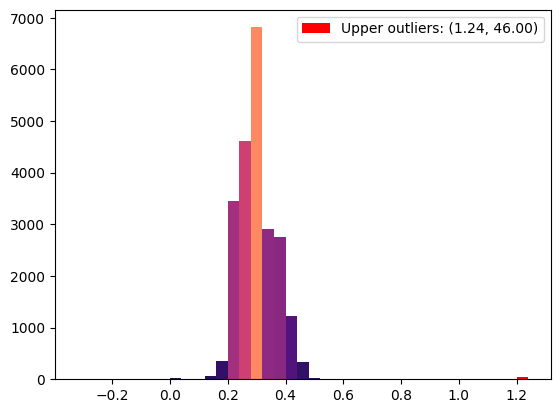

In [ ]:
adb.outliers_histogram(data=hematocrit_tomerge["hematocrit"], z_threshold=16).show()

In [ ]:
hematocrit_tomerge["hematocrit"] = hematocrit_tomerge["hematocrit"].apply(lambda x: x*100 if x<1 else x)
hematocrit_tomerge["hematocrit"] = hematocrit_tomerge["hematocrit"].apply(lambda x: round(x,2))
hematocrit_tomerge["hematocrit"].describe()

count    22631.000000
mean        30.022624
std          6.048348
min        -31.000000
25%         26.000000
50%         29.000000
75%         34.000000
max         97.000000
Name: hematocrit, dtype: float64

In [ ]:
hematocrit_tomerge = hematocrit_tomerge.loc[hematocrit_tomerge["hematocrit"]>5]
hematocrit_tomerge["hematocrit"].describe()

count    22606.000000
mean        30.056534
std          5.961351
min          6.000000
25%         26.000000
50%         29.000000
75%         34.000000
max         97.000000
Name: hematocrit, dtype: float64

In [ ]:
admissions_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23106 entries, 0 to 23105
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   admissionid                23106 non-null  Int64  
 1   patientid                  23106 non-null  Int64  
 2   location                   23106 non-null  object 
 3   specialty                  21805 non-null  object 
 4   urgency                    23106 non-null  Int64  
 5   mortality                  23106 non-null  int64  
 6   lengthofstay               23106 non-null  Int64  
 7   los_days                   23106 non-null  Int64  
 8   age_number                 23106 non-null  int64  
 9   BMI                        21624 non-null  float64
 10  sofa_respiration_score     20189 non-null  float64
 11  platelets                  22394 non-null  float64
 12  sofa_coagulation_score     22394 non-null  float64
 13  bilirubin                  23106 non-null  flo

In [ ]:
# pandas_profiling.ProfileReport(admissions_master)


# Creating final dataset with features, which will be used in model for prediction of LoS.

From dataset for model of los prediction were excluded:

*    cardiosurgical elective patients as the majority of them had los 1 day or less.
*   patients, died in ICU as they data can bias LoS values (most severe pts may die in a hours of admission)!But they can and will be included in simulation

*  patients, stayed only in MC, as they had much more shorter LoS






In [ ]:
clean_admissions_master = admissions_master.copy()

In [ ]:
Cardiochirurgie_admissions = admissions.loc[(admissions["specialty"]=="Cardiochirurgie")&(admissions["urgency"]==0)&(admissions["lengthofstay"]<=24)]


In [ ]:
Cardiochirurgie_admissions["mortality"].value_counts()
#almost no died patients, presumably non severe, just for p/o observation

0    4530
1      15
Name: mortality, dtype: int64

In [ ]:
# clean_admissions_master.drop((admissions.loc[(admissions["specialty"]=="Cardiochirurgie")&(admissions["urgency"]==0)&(admissions["lengthofstay"]<=24)]).index, inplace = True)
# clean_admissions_master.info()
#cardiosurgical elective patients who had los 1 day or less removed


In [ ]:
clean_admissions_master['location'].value_counts()

IC       16454
MC        4720
IC&MC     1848
MC&IC       84
Name: location, dtype: int64

In [ ]:
clean_admissions_master.drop((clean_admissions_master.loc[clean_admissions_master["mortality"]==1]).index, inplace = True)
clean_admissions_master.drop((clean_admissions_master.loc[clean_admissions_master["location"]=="MC"]).index, inplace = True)
clean_admissions_master.info()
#removed died and patients from MC

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16170 entries, 36 to 22613
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   admissionid                16170 non-null  Int64  
 1   patientid                  16170 non-null  Int64  
 2   location                   16170 non-null  object 
 3   specialty                  15300 non-null  object 
 4   urgency                    16170 non-null  Int64  
 5   mortality                  16170 non-null  int64  
 6   lengthofstay               16170 non-null  Int64  
 7   los_days                   16170 non-null  Int64  
 8   age_number                 16170 non-null  int64  
 9   BMI                        15233 non-null  float64
 10  sofa_respiration_score     15467 non-null  float64
 11  platelets                  15799 non-null  float64
 12  sofa_coagulation_score     15799 non-null  float64
 13  bilirubin                  16170 non-null  fl

In [ ]:
clean_admissions_master.describe()

,admissionid,patientid,urgency,mortality,lengthofstay,los_days,age_number,BMI,sofa_respiration_score,platelets,sofa_coagulation_score,bilirubin,sofa_liver_score,sofa_cardiovascular_score,sofa_cns_score,sofa_renal_score,sofa_total,sepsis_at_admission,surgical,hematocrit
count,16170.0,16170.0,16170.0,16170.0,16170.0,16170.0,16170.000000,15233.000000,15467.000000,15799.000000,15799.000000,16170.000000,16170.000000,16132.000000,11499.000000,16093.000000,10908.000000,8282.0,12024.0,15929.000000
mean,11735.844156,10132.452752,0.239889,0.0,117.052319,5.320965,63.585652,26.361255,2.215944,170.420596,0.316349,11.372356,0.094001,2.095648,0.841030,0.477972,5.851669,0.069428,0.70351,29.365811
std,6790.19035,5857.582367,0.427029,0.0,231.862238,9.68389,13.698181,4.466091,0.915008,104.505785,0.601349,13.278365,0.391726,1.364131,1.408094,0.947656,2.801426,0.254195,0.456729,5.591245
min,0.0,0.0,0.0,0.0,0.0,1.0,37.000000,16.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,6.000000
25%,5837.0,5059.0,0.0,0.0,22.0,1.0,55.000000,24.000000,2.000000,104.000000,0.000000,10.000000,0.000000,1.000000,0.000000,0.000000,4.000000,0.0,0.0,25.000000
50%,11729.5,10122.5,0.0,0.0,26.0,2.0,65.000000,25.000000,2.000000,147.000000,0.000000,10.000000,0.000000,2.000000,0.000000,0.000000,5.000000,0.0,1.0,28.000000
75%,17601.75,15200.75,0.0,0.0,96.0,5.0,75.000000,28.000000,3.000000,207.000000,1.000000,10.000000,0.000000,3.000000,1.000000,1.000000,7.000000,0.0,1.0,33.000000
max,23548.0,20322.0,1.0,0.0,4850.0,203.0,85.000000,48.000000,4.000000,1216.000000,4.000000,562.000000,4.000000,4.000000,4.000000,4.000000,19.000000,1.0,1.0,97.000000


In [ ]:
# Hospital LOS metrics for later comparison, used values in hours foe better precision
actual_mean_los = clean_admissions_master["lengthofstay"].mean()
actual_median_los = clean_admissions_master["lengthofstay"].median()

print(actual_mean_los/24)
print(actual_median_los/24)

4.877179962894249
1.0833333333333333


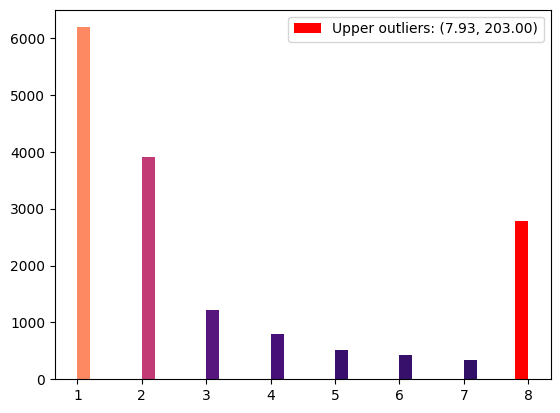

In [ ]:
adb.outliers_histogram(data=clean_admissions_master["los_days"]).show()


In [ ]:
# Re-usable plotting function
def plot_los_groupby(variable, size=(7,4)):
    '''
    Plot Median LOS by dataframe categorical series name
    '''
    results = clean_admissions_master[[variable, 'los_days']].groupby(variable).median().reset_index()
    values = list(results['los_days'].values)
    labels = list(results[variable].values)

    fig, ax = plt.subplots(figsize=size)
    ind = range(len(results))
    ax.barh(ind, values, align='center', height=0.6, color = 'powderblue', alpha=0.8)
    ax.set_yticks(ind)
    ax.set_yticklabels(labels)
    ax.set_xlabel('Median Length of Stay, days')
    ax.tick_params(left=False, top=False, right=False)
    ax.set_title('Comparison of {} labels'.format(variable))

    plt.tight_layout()
    plt.show();


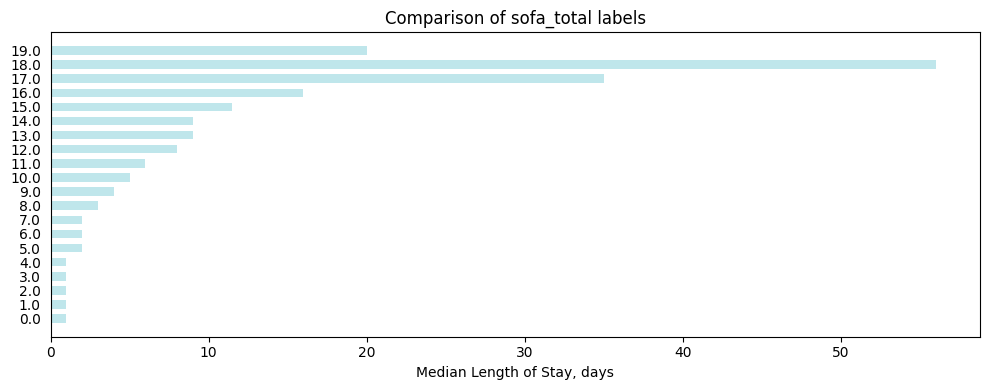

In [ ]:
plot_los_groupby("sofa_total", size=(10,4))

As seen on the plot there is a tendency for longer LoS in pts with higher SOFA score.

(1.0, 50.0)

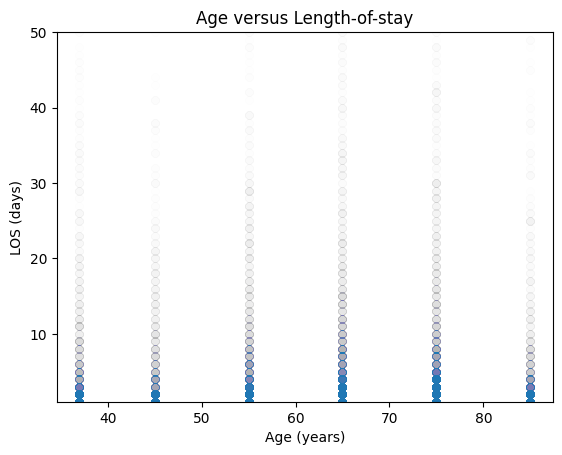

In [ ]:
plt.scatter(clean_admissions_master['age_number'], clean_admissions_master['los_days'], alpha=0.005)
plt.ylabel('LOS (days)')
plt.xlabel('Age (years)')
plt.title('Age versus Length-of-stay')
plt.ylim(1, 50)

In [ ]:
clean_admissions_master.isna().sum()
#there is a need to replace/drop null values

admissionid                     0
patientid                       0
location                        0
specialty                     870
urgency                         0
mortality                       0
lengthofstay                    0
los_days                        0
age_number                      0
BMI                           937
sofa_respiration_score        703
platelets                     371
sofa_coagulation_score        371
bilirubin                       0
sofa_liver_score                0
sofa_cardiovascular_score      38
sofa_cns_score               4671
sofa_renal_score               77
sofa_total                   5262
sepsis_at_admission          7888
surgical                     4146
hematocrit                    241
dtype: int64

In [ ]:
BMI_median = clean_admissions_master["BMI"].median()
clean_admissions_master["BMI"] = clean_admissions_master["BMI"].fillna(BMI_median)
#missin values of bmi replaced with median value

In [ ]:
clean_admissions_master["sepsis_at_admission"] = clean_admissions_master["sepsis_at_admission"].fillna(0)
clean_admissions_master["surgical"] = clean_admissions_master["surgical"].fillna(0)
clean_admissions_master["sofa_respiration_score"] = clean_admissions_master["sofa_respiration_score"].fillna(0)
clean_admissions_master["sofa_coagulation_score"] = clean_admissions_master["sofa_coagulation_score"].fillna(0)
clean_admissions_master["sofa_cardiovascular_score"] = clean_admissions_master["sofa_cardiovascular_score"].fillna(0)
clean_admissions_master["sofa_renal_score"] = clean_admissions_master["sofa_renal_score"].fillna(0)
clean_admissions_master["sofa_cns_score"] = clean_admissions_master["sofa_cns_score"].fillna(0)
clean_admissions_master["hematocrit"] = clean_admissions_master["hematocrit"].fillna(clean_admissions_master["hematocrit"].median())
clean_admissions_master["pao2/fio2"] = clean_admissions_master["pao2/fio2"].fillna(clean_admissions_master["pao2/fio2"].median())
clean_admissions_master["platelets"] = clean_admissions_master["platelets"].fillna(clean_admissions_master["platelets"].median())

#depending of the nature of the featere missing values replaced with median or 0


In [ ]:
#recalculating highest possible sofa score after replacing missing subscore values with 0
clean_admissions_master["sofa_total"] = clean_admissions_master["sofa_respiration_score"] + clean_admissions_master["sofa_liver_score"] + clean_admissions_master["sofa_coagulation_score"] + clean_admissions_master["sofa_cardiovascular_score"] + clean_admissions_master["sofa_cns_score"] + clean_admissions_master["sofa_renal_score"]

In [ ]:
clean_admissions_master.isna().sum()

In [ ]:
#drop unnecessary columns
clean_admissions_master.drop(columns=["patientid", "specialty", "admissionid", "location", "los_days" ], inplace=True)
clean_admissions_master.isna().sum()

Dataset is ready to use to train prediction model